In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [23]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from pyvenn import venn

In [3]:
%%R
data_folder = '../datasets/PXD014414_quantms/unique_peptide_target_only_psm0.01_prot0.01'
setwd(data_folder)

In [33]:
import gzip
file_name = 'out_msstats.csv.gz'
f_name = file_name.replace(".gz", "")
g_file = gzip.GzipFile(file_name)
open(f_name, "wb+").write(g_file.read())
g_file.close()


In [5]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
#library(reticulate)

protein_expression = 'protein_expression.csv'

raw.om <- read.csv('out_msstats.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"
input.om <- OpenMStoMSstatsTMTFormat(raw.om)

head(input.om)

INFO  [2021-11-26 18:33:24] ** Raw data from OpenMS imported successfully.
INFO  [2021-11-26 18:33:27] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-11-26 18:33:27] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-11-26 18:33:28] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-11-26 18:33:28] ** Shared peptides are removed.
INFO  [2021-11-26 18:33:28] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-11-26 18:33:41] ** PSMs have been aggregated to peptide ions.
INFO  [2021-11-26 18:33:45] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-11-26 18:33:47] ** For peptides overl

INFO  [2021-11-26 18:34:11] ** MSstatsTMT - proteinSummarization function
INFO  [2021-11-26 18:34:12] Summarizing for Run : 2_2_2 ( 1  of  3 )
  |======================================================================| 100%
INFO  [2021-11-26 18:35:21] Summarizing for Run : 3_3_3 ( 2  of  3 )
  |======================================================================| 100%
INFO  [2021-11-26 18:36:27] Summarizing for Run : 1_1_1 ( 3  of  3 )
  |======================================================================| 100%
INFO  [2021-11-26 18:37:29] ** Protein-level summarization done by MSstats.
[1] "metaplastic breast carcinomas|Chondroid"      
[2] "metaplastic breast carcinomas|Spindle"        
[3] "metaplastic breast carcinomas|Squamous"       
[4] "Normal|Normal breast"                         
[5] "Triple-negative breast cancer|Triple-negative"


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



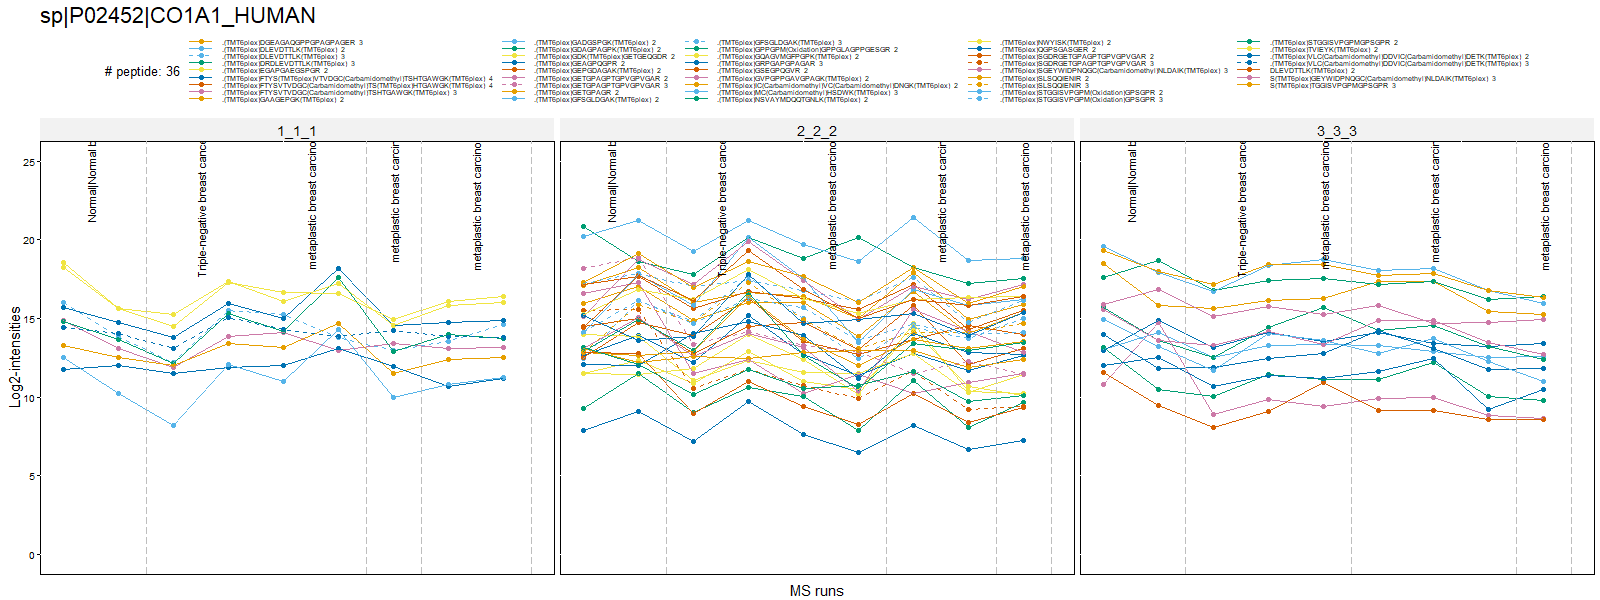

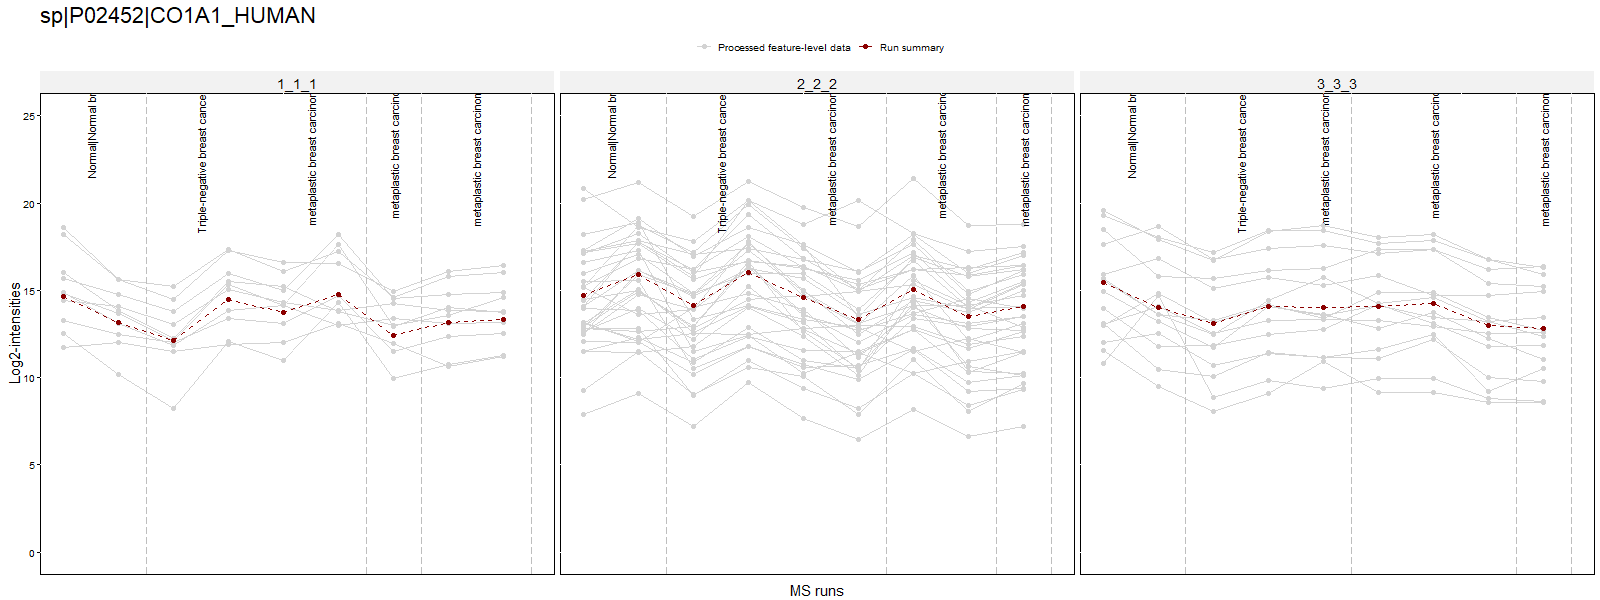

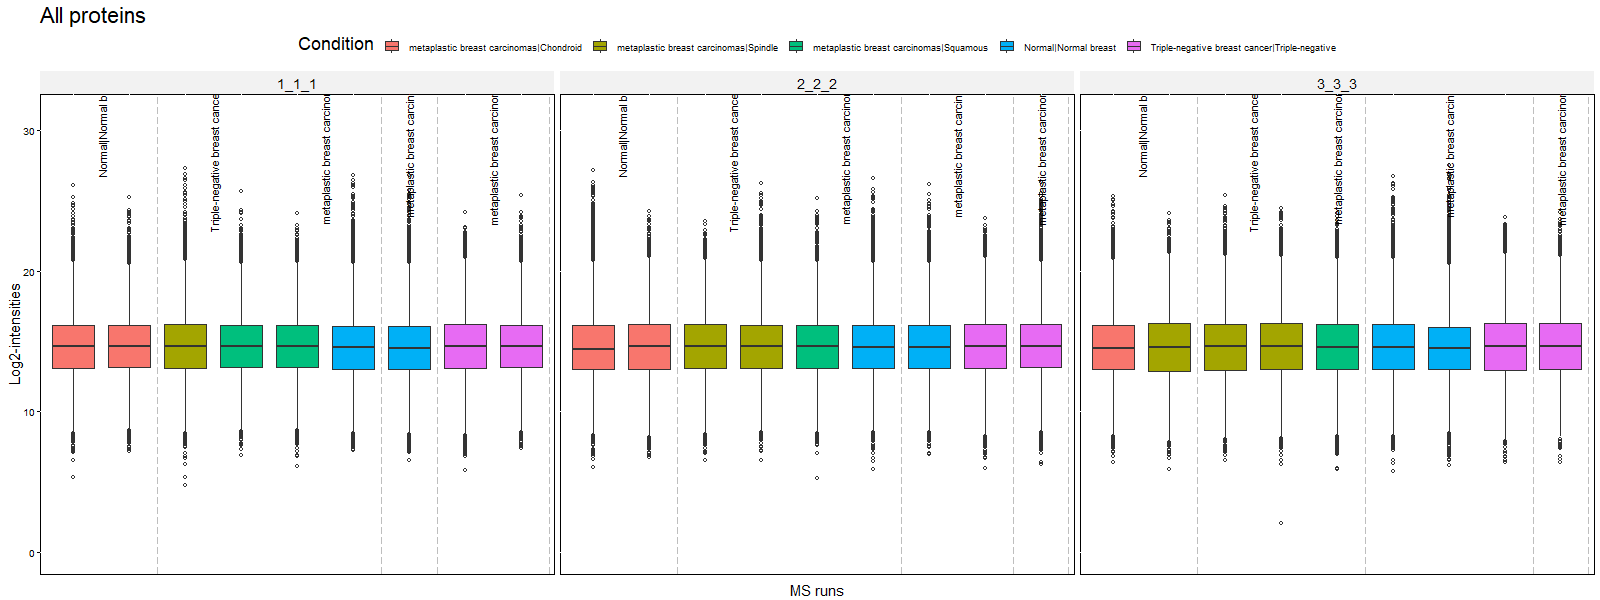

In [6]:
%%R -w 1600 -h 600

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

print(levels(quant_om.msstats$ProteinLevelData$Condition))

protein_expression = './protein_expression.csv'

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P02452|CO1A1_HUMAN',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]
write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)

In [7]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "metaplastic breast carcinomas|Chondroid"      
[2] "metaplastic breast carcinomas|Spindle"        
[3] "metaplastic breast carcinomas|Squamous"       
[4] "Normal|Normal breast"                         
[5] "Triple-negative breast cancer|Triple-negative"


In [8]:
%%R -w 1000 -h 600

Within_Subtype_Comp<-matrix(c(-1,-1,0,0,1,1,1,0,-1,0,0,0,0,0,0),nrow=3)
row.names(Within_Subtype_Comp)<-c("SQUAMOUS vs SARCOMATOID", "SPINDLE vs SARCOMATOID", "SPINDLE vs SQUAMOUS")
colnames(Within_Subtype_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Within_Subtype_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Within_Subtype_Comp, moderated = TRUE)

Within_Subtype_Comp['SQUAMOUS vs SARCOMATOID',]

INFO  [2021-11-26 18:38:07] Model fitting for 5069 proteins.
  |======================================================================| 100%
INFO  [2021-11-26 18:40:57] Testing for 5069 proteins:
  |======================================================================| 100%
      metaplastic breast carcinomas|Chondroid 
                                           -1 
        metaplastic breast carcinomas|Spindle 
                                            0 
       metaplastic breast carcinomas|Squamous 
                                            1 
                         Normal|Normal breast 
                                            0 
Triple-negative breast cancer|Triple-negative 
                                            0 


In [9]:
%%R

Within_Subtype_Comp = Within_Subtype_Comp.pairwise$ComparisonResult
write.table(Within_Subtype_Comp,"Within_Subtype_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

### MBC_three_subclasses comparing based on results given by author

                     Protein                    Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  SQUAMOUS vs SARCOMATOID  1.849715  0.170908   
1   sp|A0A075B6H7|KV37_HUMAN   SPINDLE vs SARCOMATOID  0.217056  0.889342   
2   sp|A0A075B6H7|KV37_HUMAN      SPINDLE vs SQUAMOUS -1.632659  0.310619   
3  sp|A0A075B6I0|LV861_HUMAN  SQUAMOUS vs SARCOMATOID -1.703542  0.004881   
4  sp|A0A075B6I0|LV861_HUMAN   SPINDLE vs SARCOMATOID -0.455573  0.370977   

   -Log10(p-value)    group  
0         0.767238  dimgrey  
1         0.050931  dimgrey  
2         0.507772  dimgrey  
3         2.311514     down  
4         0.430653  dimgrey  


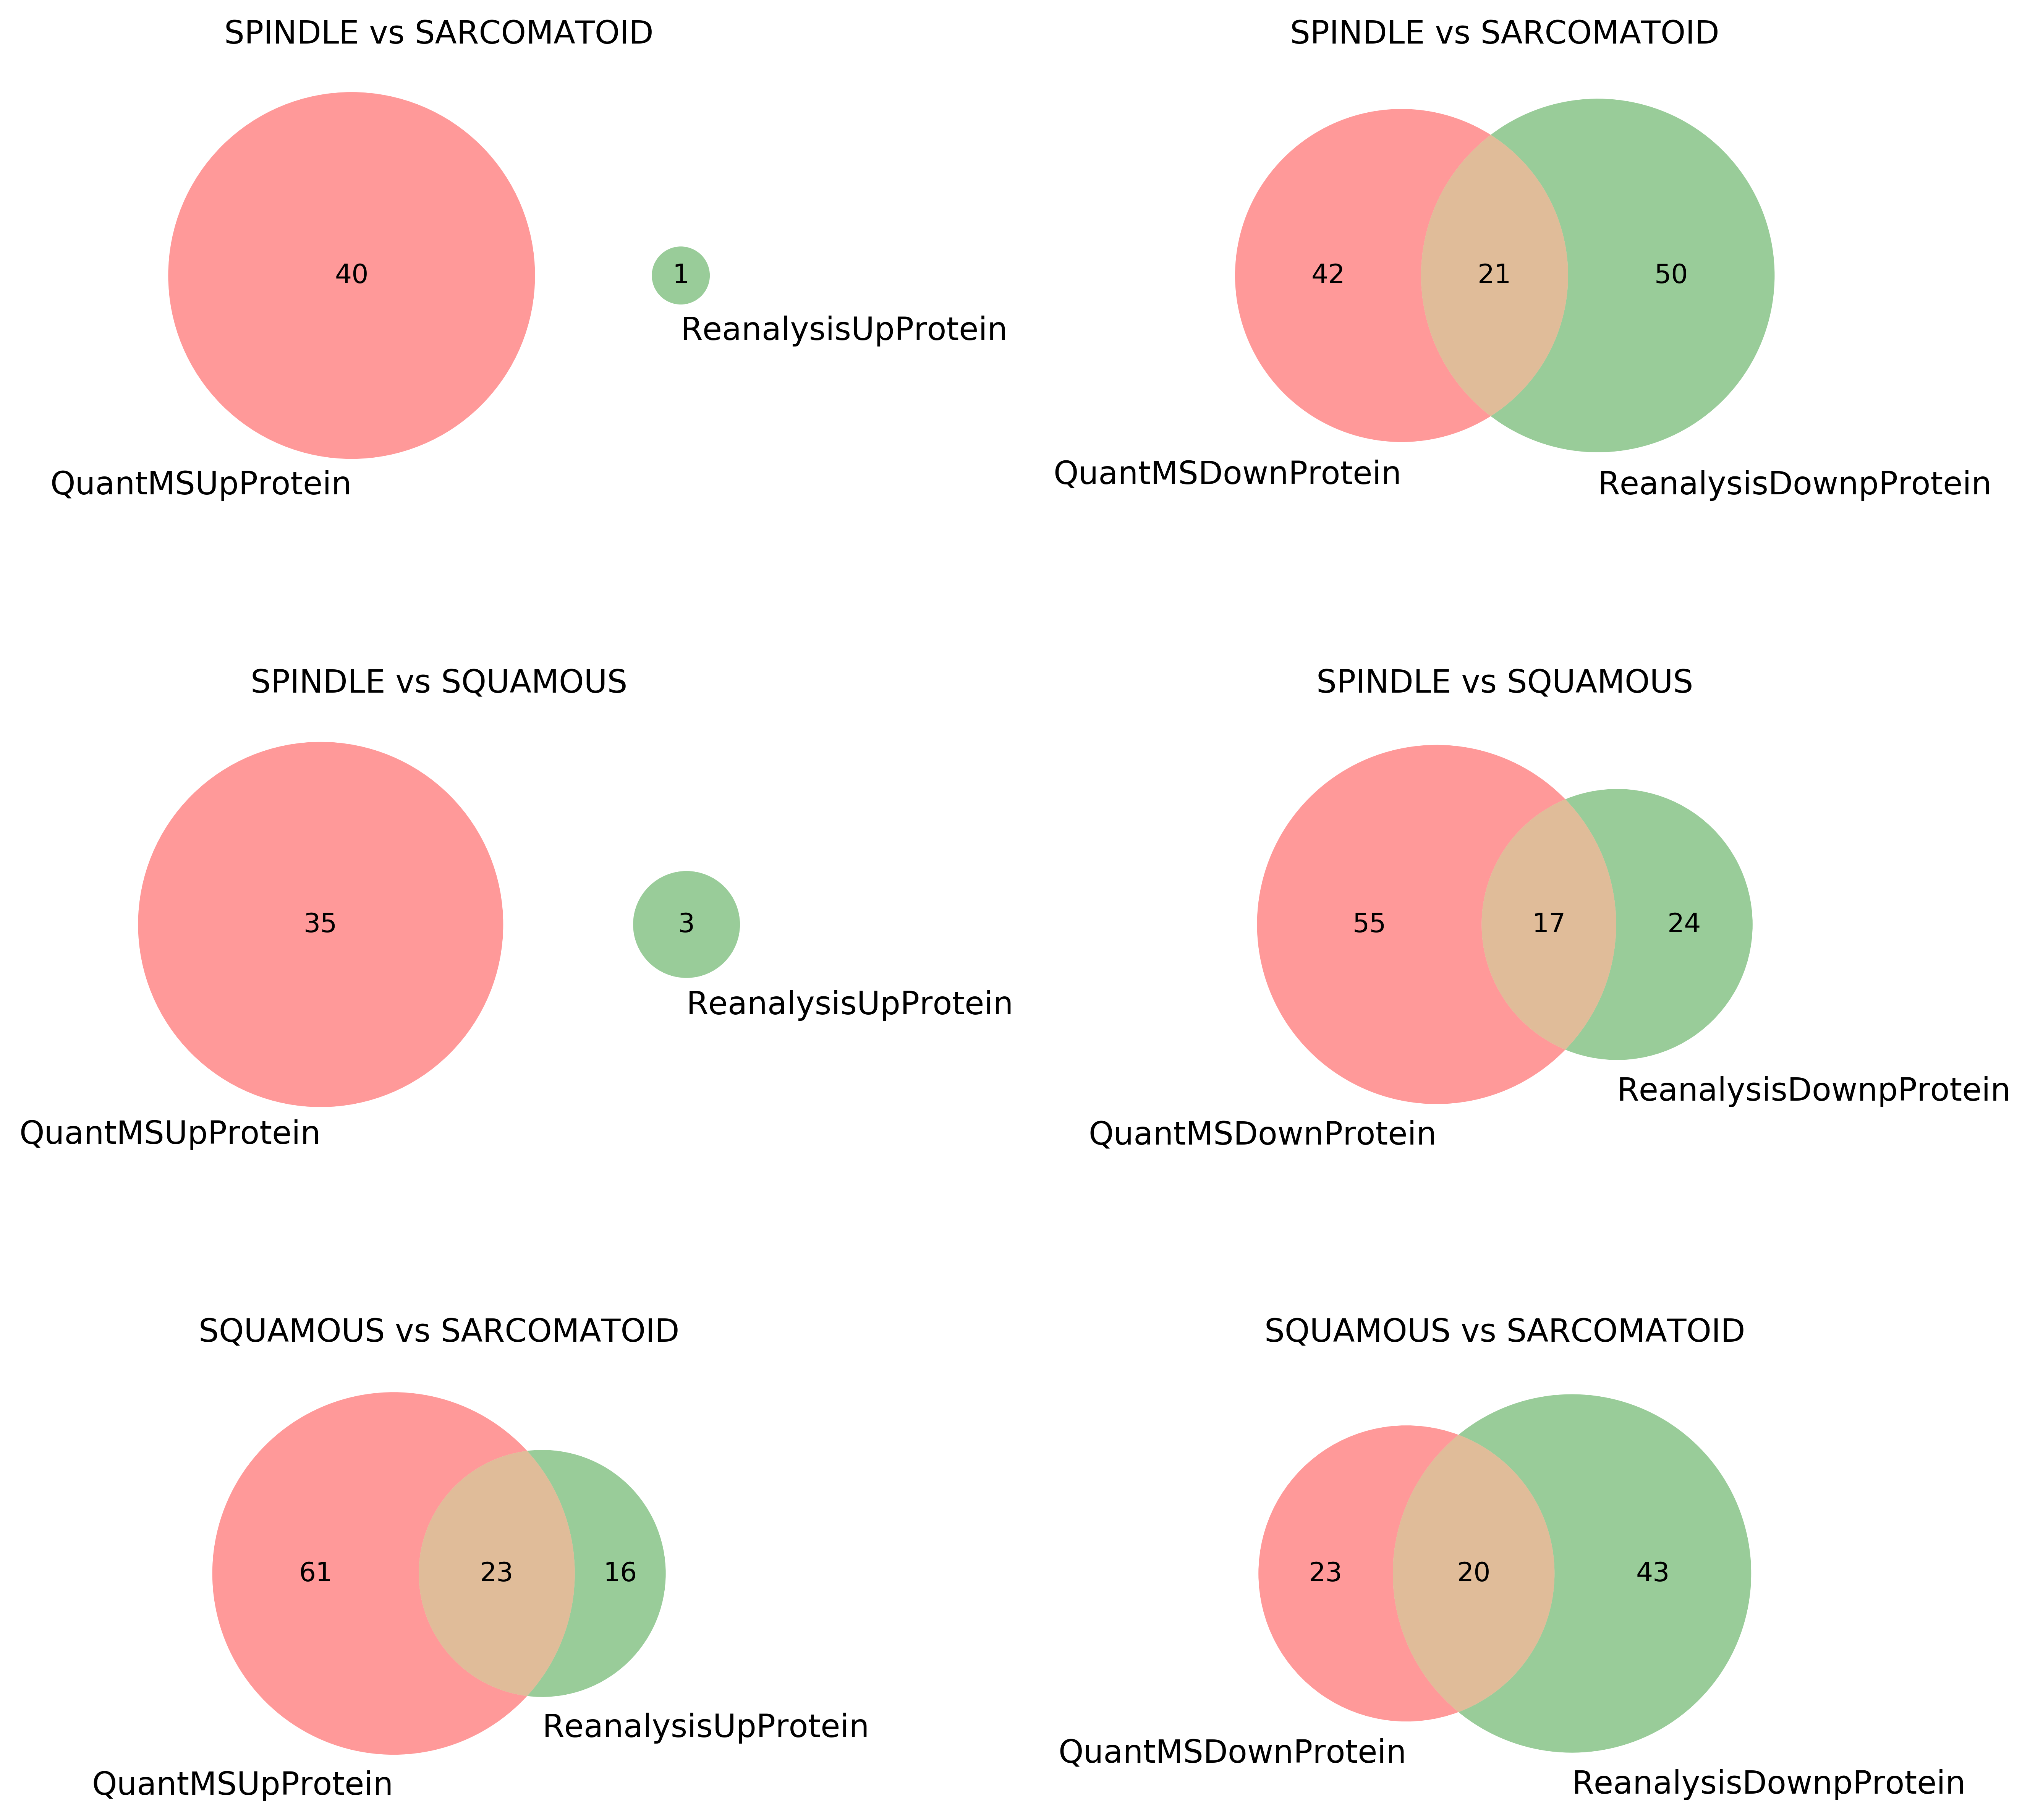

In [30]:
from matplotlib_venn import venn2


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

result = pd.read_csv('./Within_Subtype_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'up' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'down'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())

# read re-analysis result
reanalysis_res = pd.read_csv("./PXD014414_MBC_three_subclasses_results.txt",
                            sep="\t")


fig = plt.figure(figsize=(12, 12), dpi=500)
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    if comp == "SQUAMOUS vs SARCOMATOID":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_C_Sq'] != 'no')&(reanalysis_res['direction_C_Sq'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_C_Sq'] != 'no')&(reanalysis_res['direction_C_Sq'] == 'up')]['Accession'].tolist()
    elif comp == "SPINDLE vs SARCOMATOID":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_C_Sp'] != 'no')&(reanalysis_res['direction_C_Sp'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_C_Sp'] != 'no')&(reanalysis_res['direction_C_Sp'] == 'up')]['Accession'].tolist()
    elif comp == "SPINDLE vs SQUAMOUS":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_Sp_Sq'] != 'no')&(reanalysis_res['direction_Sp_Sq'] == 'up')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_Sp_Sq'] != 'no')&(reanalysis_res['direction_Sp_Sq'] == 'down')]['Accession'].tolist()
        
    ax = fig.add_subplot(320 + i)
    OurUpProtein = data[data['group'] == "up"]['Protein'].tolist()
    OurDownProtein = data[data['group'] == "down"]['Protein'].tolist()
    
    i += 1
    ax.set_title(comp)
    venn2(subsets=[set(OurUpProtein), set(reanalysis_upProtein)], set_labels=('QuantMSUpProtein', 'ReanalysisUpProtein'), ax=ax)
    
    ax = fig.add_subplot(320 + i)
    ax.set_title(comp)
    venn2(subsets=[set(OurDownProtein), set(reanalysis_downProtein)], set_labels=('QuantMSDownProtein', 'ReanalysisDownpProtein'), ax=ax)
    i += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

### MBC_three_subclasses comparing based on log2FC、PValue

                     Protein                    Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  SQUAMOUS vs SARCOMATOID  1.849715  0.170908   
1   sp|A0A075B6H7|KV37_HUMAN   SPINDLE vs SARCOMATOID  0.217056  0.889342   
2   sp|A0A075B6H7|KV37_HUMAN      SPINDLE vs SQUAMOUS -1.632659  0.310619   
3  sp|A0A075B6I0|LV861_HUMAN  SQUAMOUS vs SARCOMATOID -1.703542  0.004881   
4  sp|A0A075B6I0|LV861_HUMAN   SPINDLE vs SARCOMATOID -0.455573  0.370977   

   -Log10(p-value)    group  
0         0.767238  dimgrey  
1         0.050931  dimgrey  
2         0.507772  dimgrey  
3         2.311514     down  
4         0.430653  dimgrey  


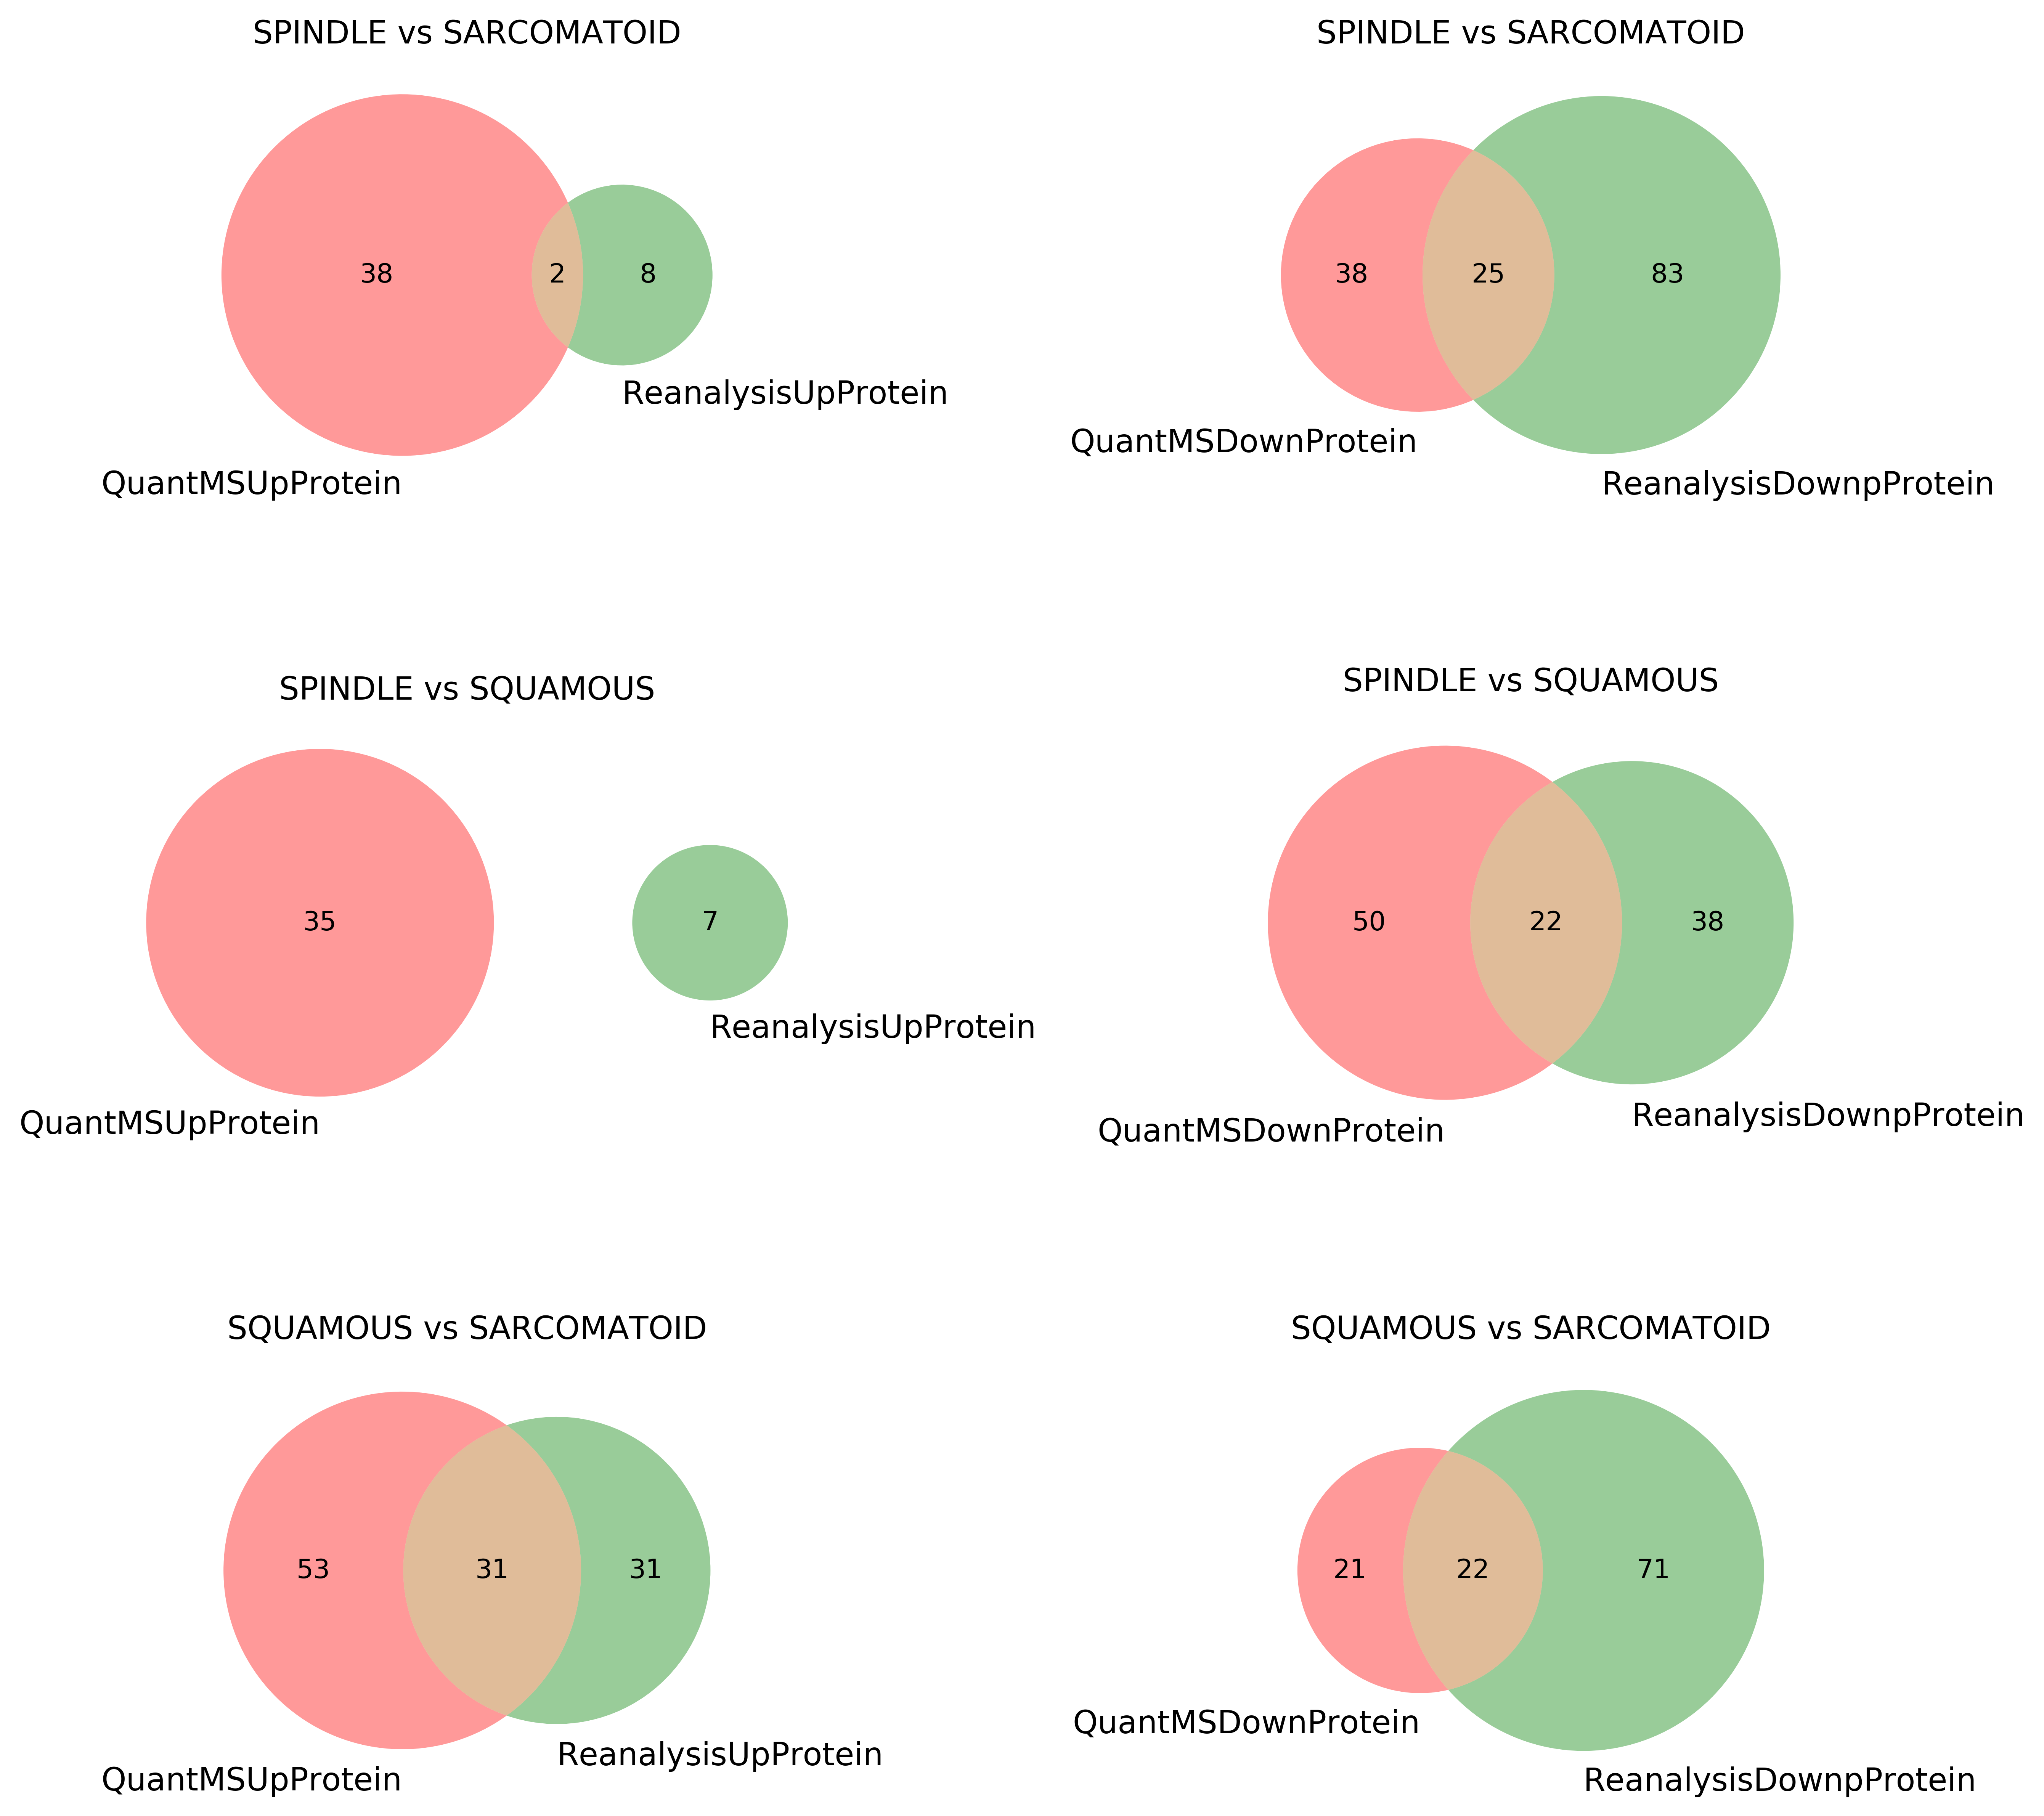

In [31]:
from matplotlib_venn import venn2


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

result = pd.read_csv('./Within_Subtype_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'up' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'down'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())

# read re-analysis result
reanalysis_res = pd.read_csv("./PXD014414_MBC_three_subclasses_results.txt",
                            sep="\t")


fig = plt.figure(figsize=(12, 12), dpi=500)
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    if comp == "SQUAMOUS vs SARCOMATOID":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_C_Sq'] < -1)&(reanalysis_res['PValue_C_Sq'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_C_Sq'] > 1)&(reanalysis_res['PValue_C_Sq'] < 0.01)]['Accession'].tolist()
    elif comp == "SPINDLE vs SARCOMATOID":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_C_Sp'] < -1)&(reanalysis_res['PValue_C_Sp'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_C_Sp'] > 1)&(reanalysis_res['PValue_C_Sp'] < 0.01)]['Accession'].tolist()
    elif comp == "SPINDLE vs SQUAMOUS":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_Sp_Sq'] > 1)&(reanalysis_res['PValue_Sp_Sq'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_Sp_Sq'] < -1)&(reanalysis_res['PValue_Sp_Sq'] < 0.01)]['Accession'].tolist()
        
    ax = fig.add_subplot(320 + i)
    OurUpProtein = data[data['group'] == "up"]['Protein'].tolist()
    OurDownProtein = data[data['group'] == "down"]['Protein'].tolist()
    
    i += 1
    ax.set_title(comp)
    venn2(subsets=[set(OurUpProtein), set(reanalysis_upProtein)], set_labels=('QuantMSUpProtein', 'ReanalysisUpProtein'), ax=ax)
    
    ax = fig.add_subplot(320 + i)
    ax.set_title(comp)
    venn2(subsets=[set(OurDownProtein), set(reanalysis_downProtein)], set_labels=('QuantMSDownProtein', 'ReanalysisDownpProtein'), ax=ax)
    i += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


### (1) Triple Negative versus Normal, MBC versus Normal and MBC versus TNBC

In [13]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]
raw.om$Condition[which(raw.om$Condition == "metaplastic breast carcinomas|Chondroid"|raw.om$Condition=="metaplastic breast carcinomas|Spindle"|raw.om$Condition=="metaplastic breast carcinomas|Squamous")] <- "MBC"
raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

print(levels(quant_om.msstats$ProteinLevelData$Condition))

INFO  [2021-11-26 18:53:48] ** Raw data from OpenMS imported successfully.
INFO  [2021-11-26 18:53:51] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-11-26 18:53:51] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-11-26 18:53:52] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-11-26 18:53:52] ** Shared peptides are removed.
INFO  [2021-11-26 18:53:52] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-11-26 18:54:03] ** PSMs have been aggregated to peptide ions.
INFO  [2021-11-26 18:54:06] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-11-26 18:54:08] ** For peptides overl

In [14]:
%%R

Main_Comp<-matrix(c(1,1,0, 0, -1, -1, -1, 0, 1),nrow=3)
row.names(Main_Comp)<-c("MBC vs TNBC", "MBC vs Normal", "TNBC vs Normal")
colnames(Main_Comp) = c("MBC","Normal|Normal breast", "Triple-negative breast cancer|Triple-negative")


Main_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Main_Comp, moderated = TRUE)
Main_Comp = Main_Comp.pairwise$ComparisonResult
write.table(Main_Comp,"Main_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-11-26 19:00:23] Model fitting for 5069 proteins.
  |======================================================================| 100%
INFO  [2021-11-26 19:03:08] Testing for 5069 proteins:
  |======================================================================| 100%


                     Protein           Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN     MBC vs TNBC  0.016080  0.988255   
1   sp|A0A075B6H7|KV37_HUMAN   MBC vs Normal -2.489884  0.040947   
2   sp|A0A075B6H7|KV37_HUMAN  TNBC vs Normal -2.505964  0.076727   
3  sp|A0A075B6I0|LV861_HUMAN     MBC vs TNBC  0.563282  0.223648   
4  sp|A0A075B6I0|LV861_HUMAN   MBC vs Normal -0.833738  0.076046   

   -Log10(p-value)    group  
0         0.005131  dimgrey  
1         1.387779  dimgrey  
2         1.115054  dimgrey  
3         0.650435  dimgrey  
4         1.118922  dimgrey  
MBC vs Normal
MBC vs TNBC
TNBC vs Normal


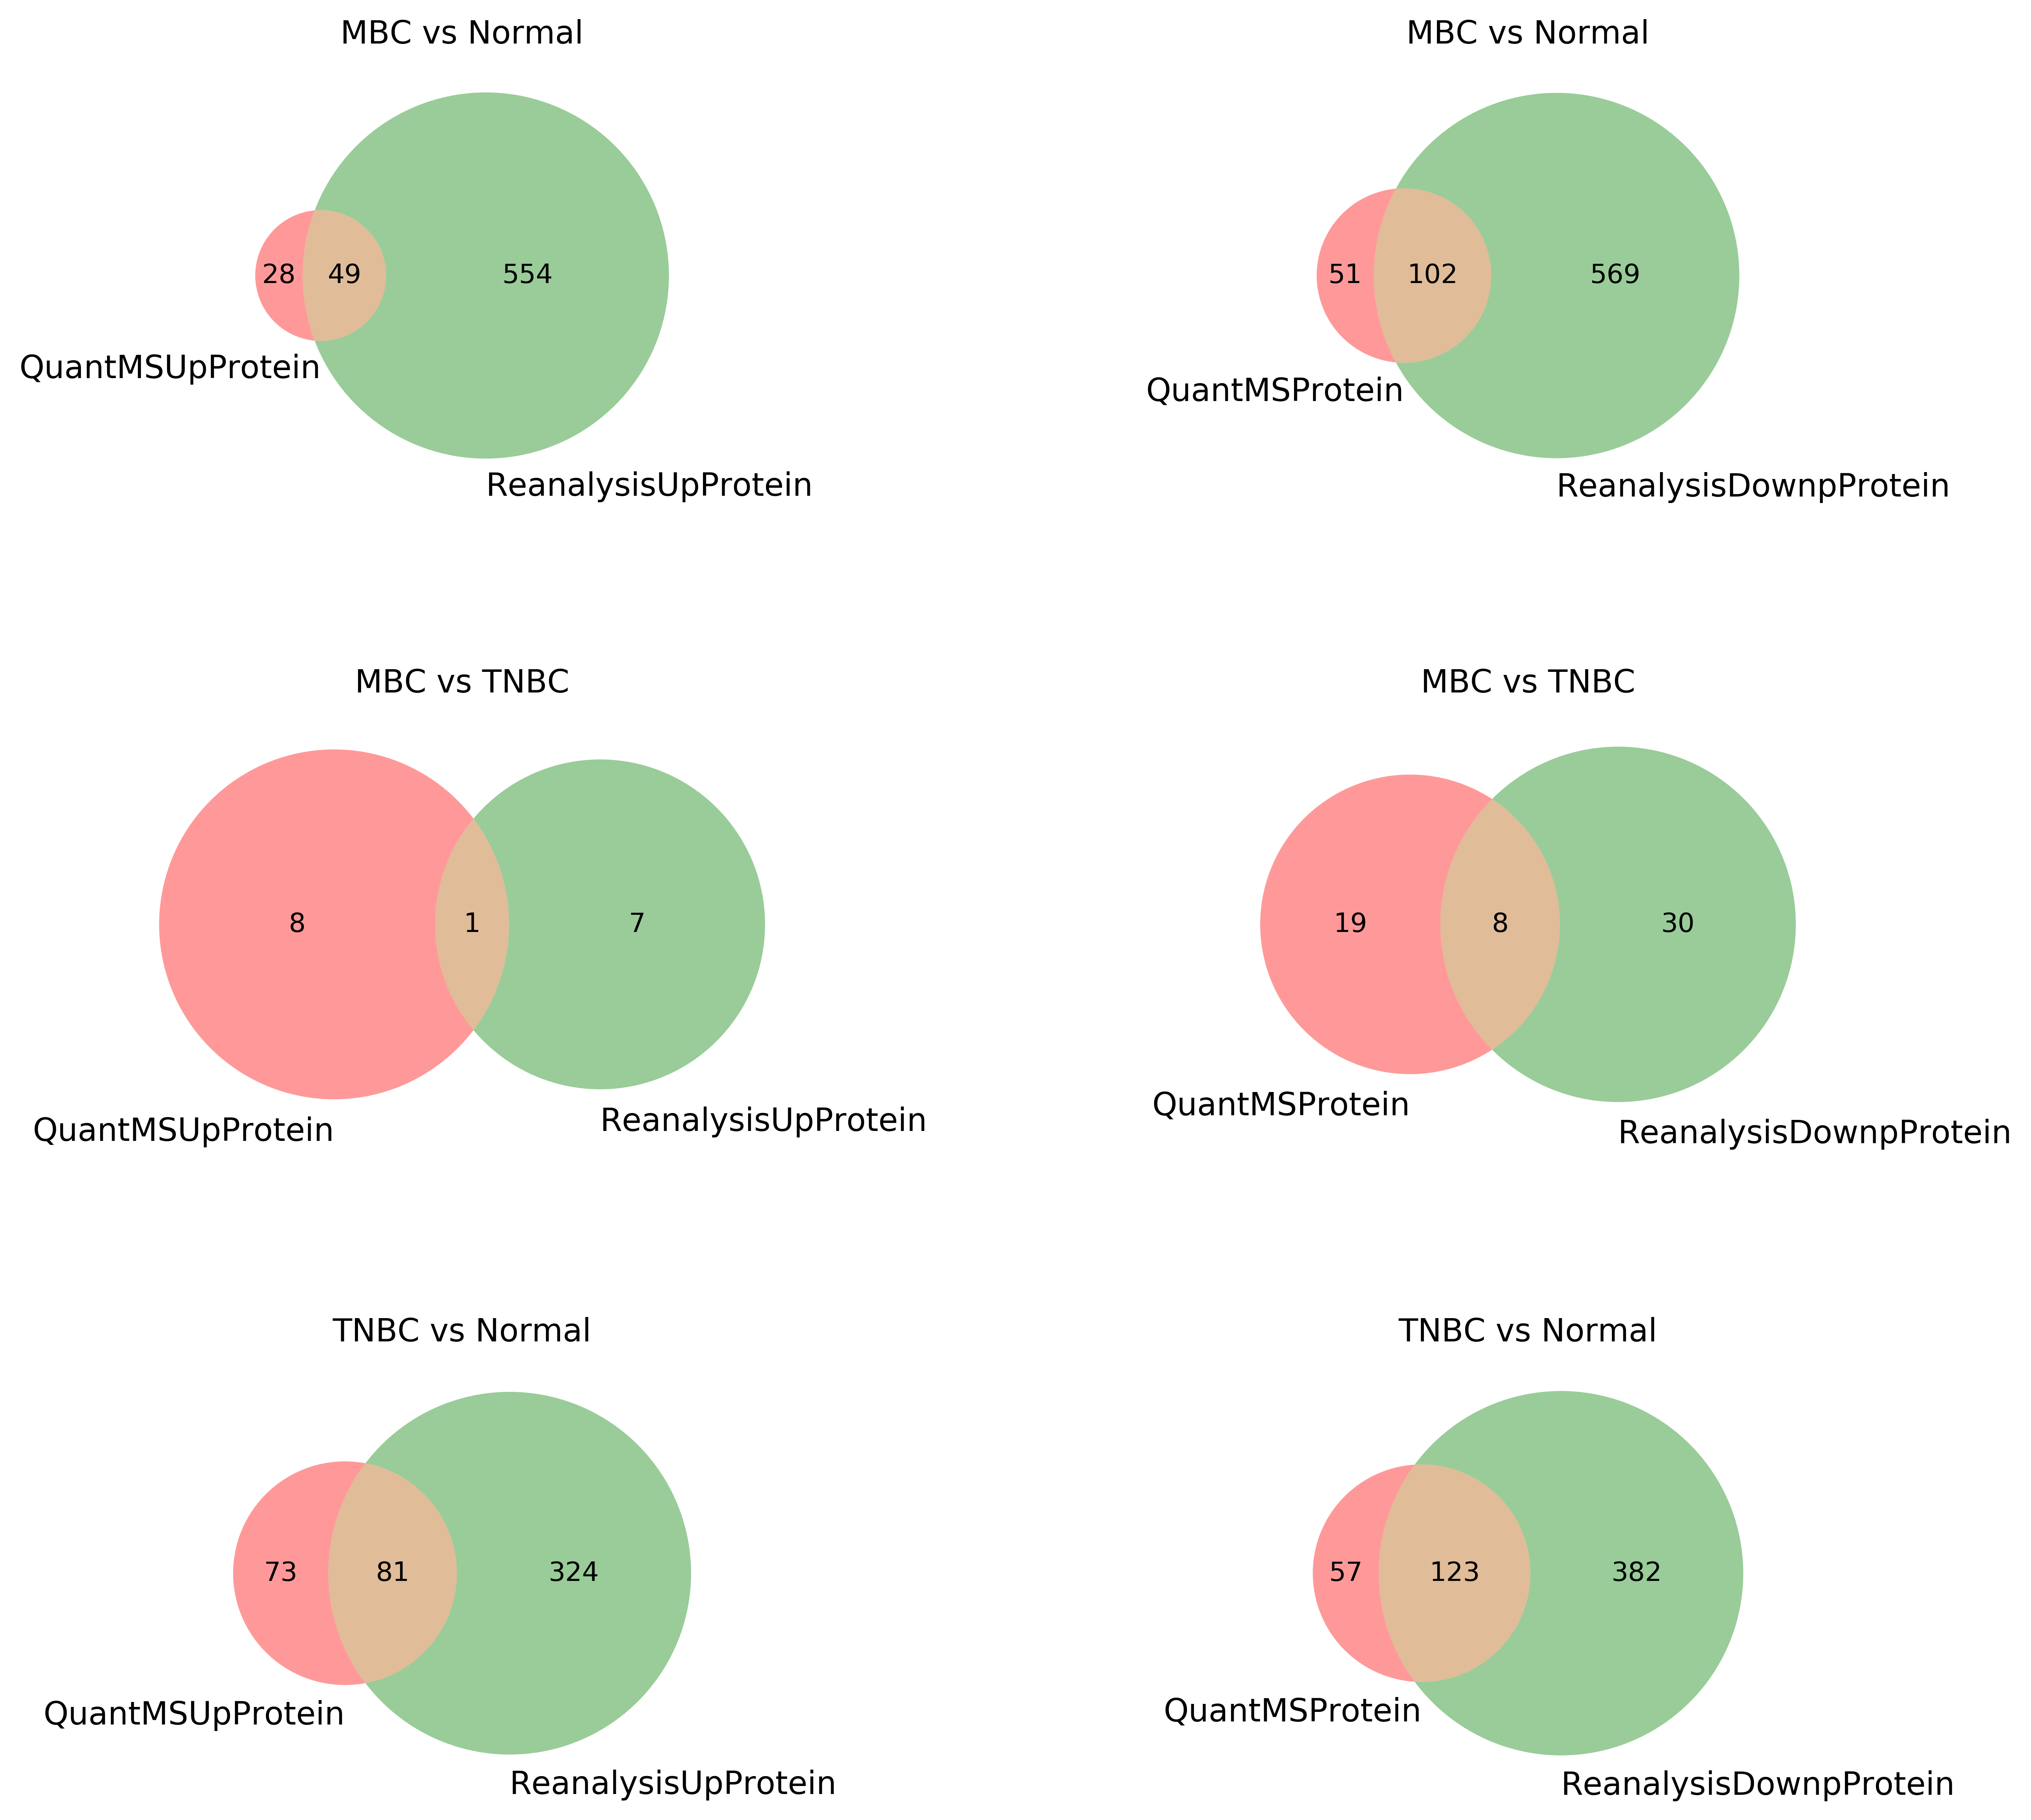

In [15]:
result = pd.read_csv('./Main_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'up' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'down'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())

# read re-analysis result
reanalysis_res = pd.read_csv("./PXD014414_three_tissues_results.txt",
                            sep="\t")


fig = plt.figure(figsize=(12, 12), dpi=500)
i = 1
for comp in np.unique(result['Label']):
    print(comp)
    data = result[result['Label'] == comp]
    if comp == "MBC vs TNBC":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_TN_MBC'] != 'no')&(reanalysis_res['direction_TN_MBC'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_TN_MBC'] != 'no')&(reanalysis_res['direction_TN_MBC'] == 'up')]['Accession'].tolist()
    elif comp == "MBC vs Normal":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_N_MBC'] != 'no')&(reanalysis_res['direction_N_MBC'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_N_MBC'] != 'no')&(reanalysis_res['direction_N_MBC'] == 'up')]['Accession'].tolist()
    elif comp == "TNBC vs Normal":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_N_TN'] != 'no')&(reanalysis_res['direction_N_TN'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_N_TN'] != 'no')&(reanalysis_res['direction_N_TN'] == 'up')]['Accession'].tolist()
        
    ax = fig.add_subplot(320 + i)
    OurUpProtein = data[data['group'] == "up"]['Protein'].tolist()
    OurDownProtein = data[data['group'] == "down"]['Protein'].tolist()
    
    i += 1
    ax.set_title(comp)

    venn2(subsets=[set(OurUpProtein), set(reanalysis_upProtein)], set_labels=('QuantMSUpProtein', 'ReanalysisUpProtein'), ax=ax)
    
    ax = fig.add_subplot(320 + i)
    ax.set_title(comp)
    venn2(subsets=[set(OurDownProtein), set(reanalysis_downProtein)], set_labels=('QuantMSProtein', 'ReanalysisDownpProtein'), ax=ax)
    i += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


                     Protein           Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN     MBC vs TNBC  0.016080  0.988255   
1   sp|A0A075B6H7|KV37_HUMAN   MBC vs Normal -2.489884  0.040947   
2   sp|A0A075B6H7|KV37_HUMAN  TNBC vs Normal -2.505964  0.076727   
3  sp|A0A075B6I0|LV861_HUMAN     MBC vs TNBC  0.563282  0.223648   
4  sp|A0A075B6I0|LV861_HUMAN   MBC vs Normal -0.833738  0.076046   

   -Log10(p-value)    group  
0         0.005131  dimgrey  
1         1.387779  dimgrey  
2         1.115054  dimgrey  
3         0.650435  dimgrey  
4         1.118922  dimgrey  


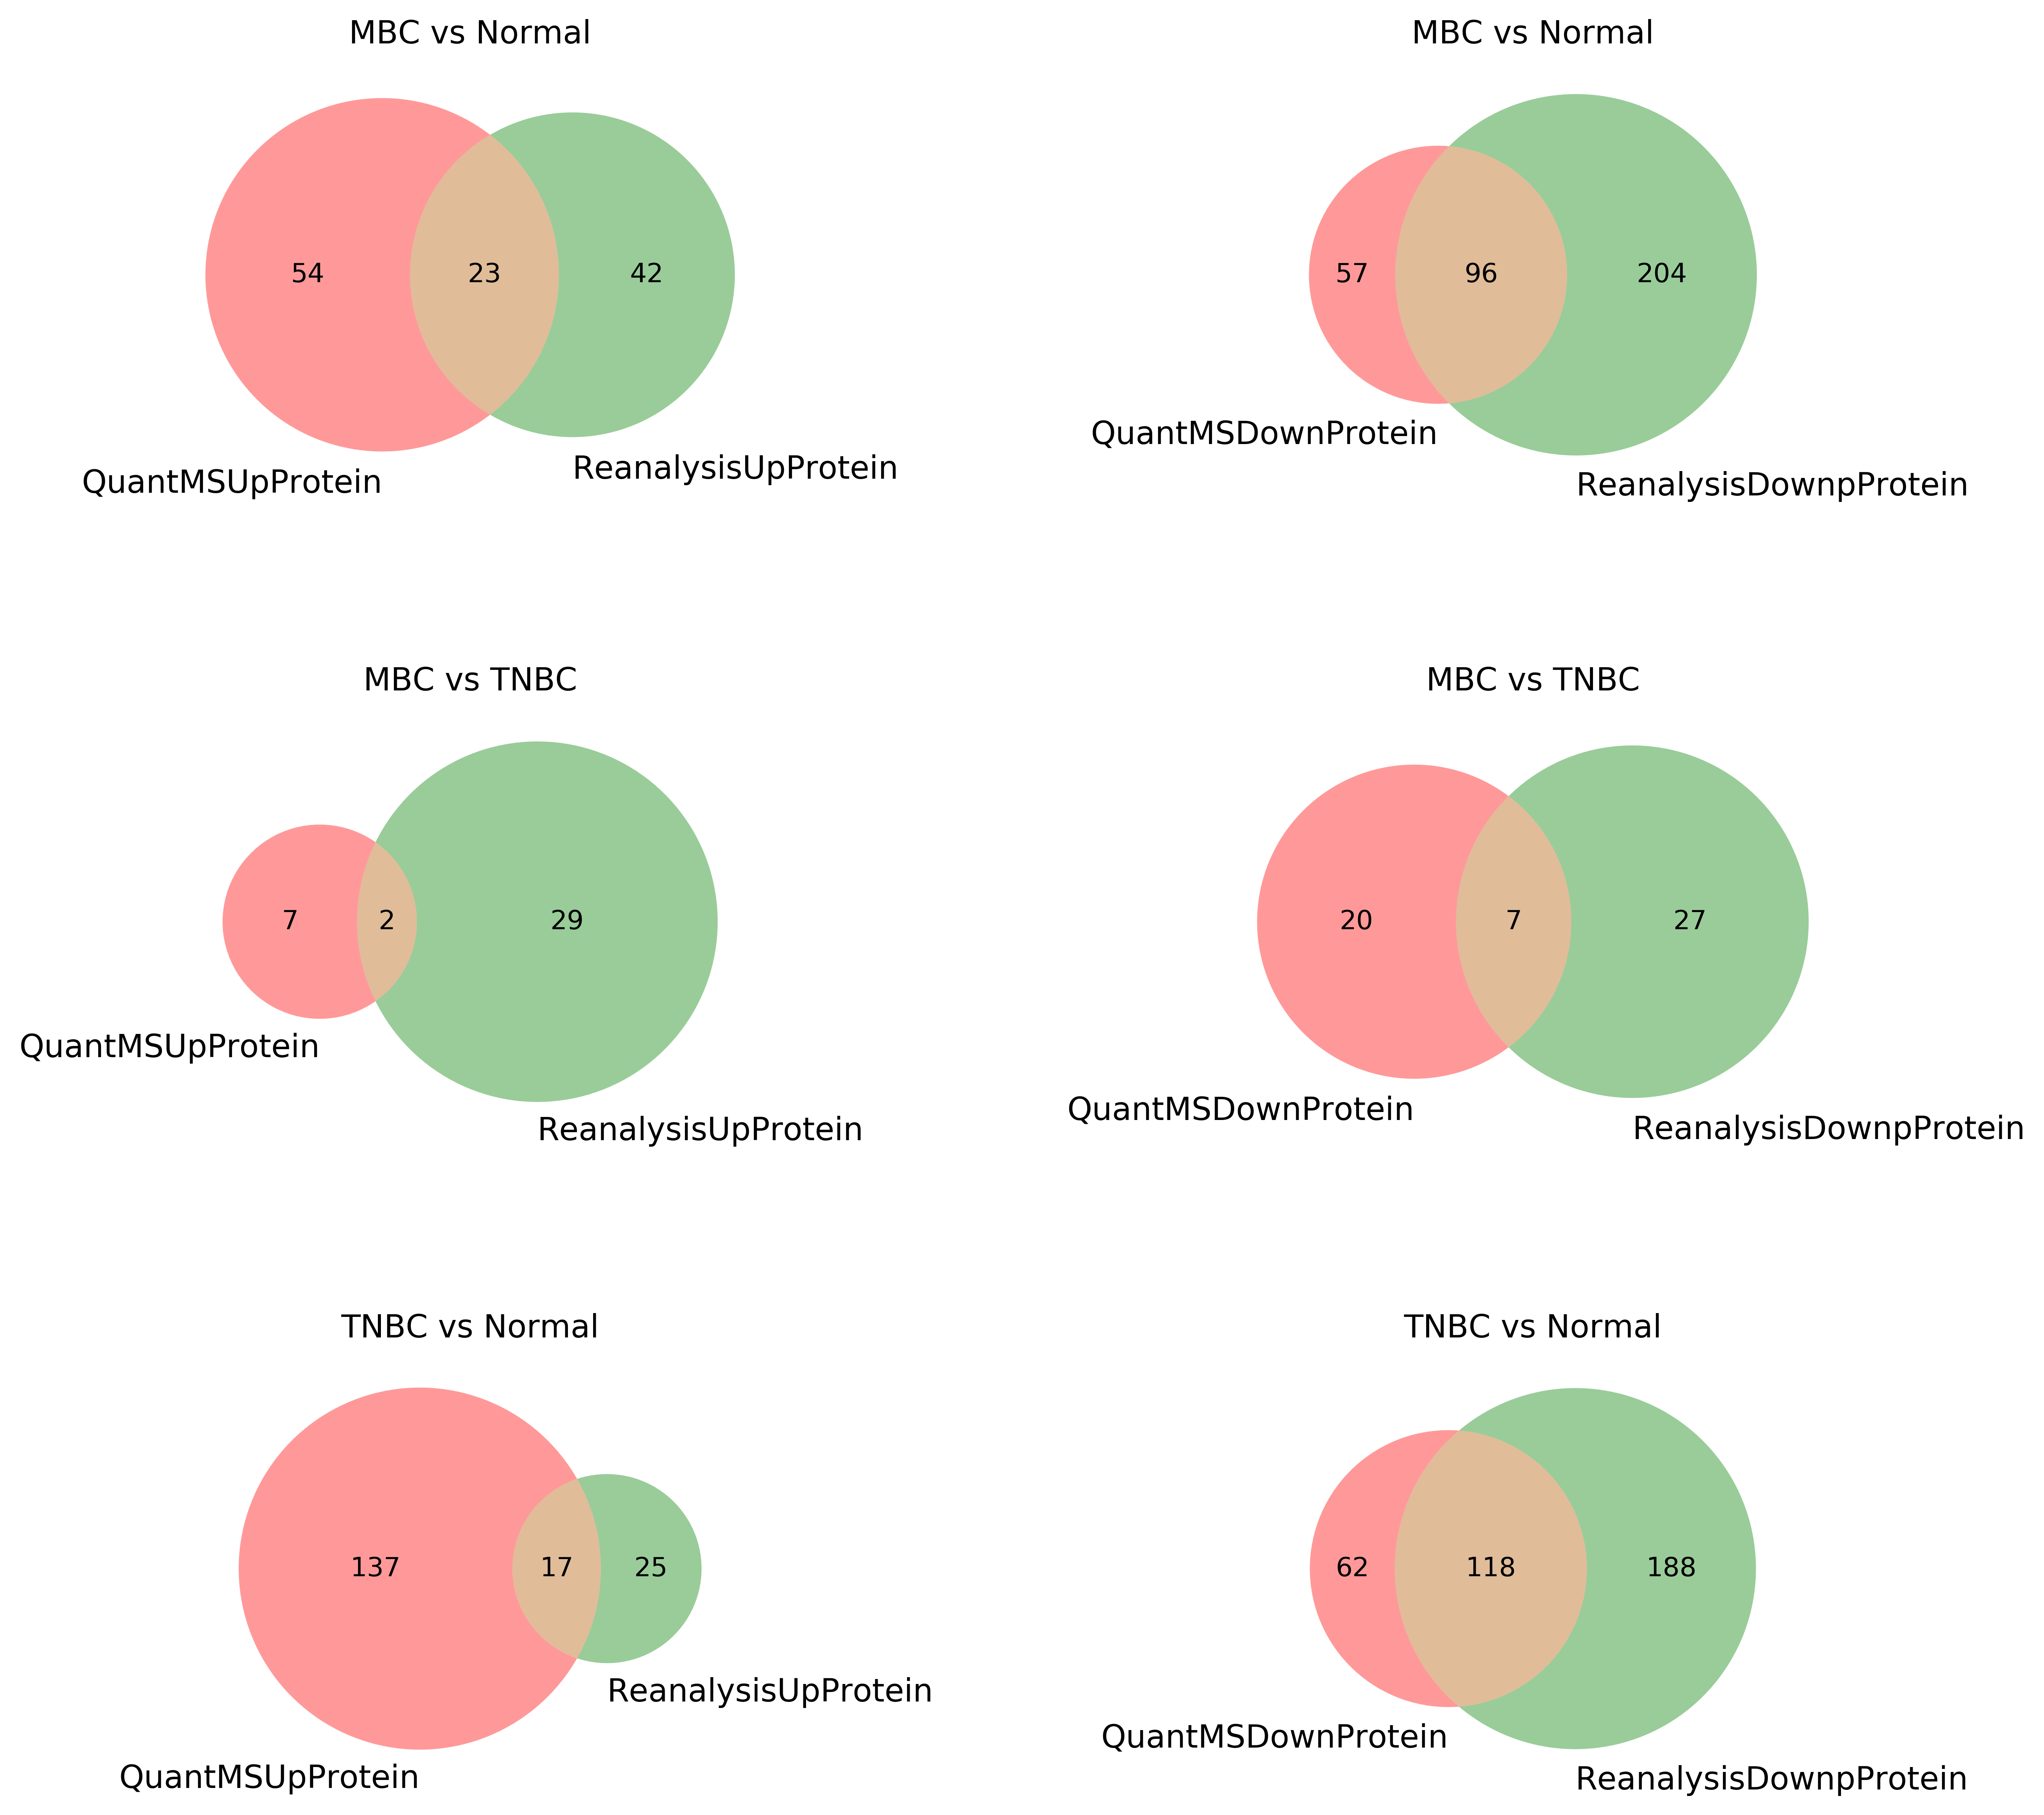

In [16]:
result = pd.read_csv('./Main_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'up' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'down'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())

# read re-analysis result
reanalysis_res = pd.read_csv("./PXD014414_three_tissues_results.txt",
                            sep="\t")


fig = plt.figure(figsize=(12, 12), dpi=500)
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    if comp == "MBC vs TNBC":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_TN_MBC'] < -1)&(reanalysis_res['PValue_TN_MBC'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_TN_MBC'] > 1)&(reanalysis_res['PValue_TN_MBC'] < 0.01)]['Accession'].tolist()
    elif comp == "MBC vs Normal":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_N_MBC'] < -1)&(reanalysis_res['PValue_N_MBC'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_N_MBC'] > 1)&(reanalysis_res['PValue_N_MBC'] < 0.01)]['Accession'].tolist()
    elif comp == "TNBC vs Normal":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_N_TN'] < -1)&(reanalysis_res['PValue_N_TN'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_N_TN'] > 1)&(reanalysis_res['PValue_N_TN'] < 0.01)]['Accession'].tolist()
        
    ax = fig.add_subplot(320 + i)
    OurUpProtein = data[data['group'] == "up"]['Protein'].tolist()
    OurDownProtein = data[data['group'] == "down"]['Protein'].tolist()
    
    i += 1
    ax.set_title(comp)
    venn2(subsets=[set(OurUpProtein), set(reanalysis_upProtein)], set_labels=('QuantMSUpProtein', 'ReanalysisUpProtein'), ax=ax)
    
    ax = fig.add_subplot(320 + i)
    ax.set_title(comp)
    venn2(subsets=[set(OurDownProtein), set(reanalysis_downProtein)], set_labels=('QuantMSDownProtein', 'ReanalysisDownpProtein'), ax=ax)
    i += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


In [17]:
# map protein to gene name
import re
import urllib.parse
import urllib.request

def MapProtGeneName(prots):
    url = 'https://www.uniprot.org/uploadlists/'
    query = ' '.join(prots)
    params = {
    'from': 'ACC+ID',
    'to': 'GENENAME',
    'format': 'tab',
    'query':query
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        data = response.decode('utf-8')
        r = {}
        keys = re.split('\t|\n', data)[::2][1:-1]
        values = re.split('\t|\n', data)[1::2][1:]
        for i in range(len(keys)):
            if keys[i] in r:
                r[keys[i]] = r[keys[i]] + "/" + values[i]
            else:
                r[keys[i]] = values[i]     
    return r

### Tests for significant changes in protein abundance across conditions

In [18]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats.csv'

raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

INFO  [2021-11-26 19:17:16] ** Raw data from OpenMS imported successfully.
INFO  [2021-11-26 19:17:18] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-11-26 19:17:18] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-11-26 19:17:19] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-11-26 19:17:19] ** Shared peptides are removed.
INFO  [2021-11-26 19:17:19] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-11-26 19:17:32] ** PSMs have been aggregated to peptide ions.
INFO  [2021-11-26 19:17:35] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-11-26 19:17:37] ** For peptides overl

In [19]:
%%R -w 1000 -h 600

Cancer_Normal_Comp<-matrix(c(0,0,1,0,1,0,0,0,0,1,0,0,-1,-1,-1,-1,0,0,0,1),nrow=4)
row.names(Cancer_Normal_Comp)<-c("MBC Spindle vs Normal", "MBC Squamous vs Normal", "MBC Sarcomatoid vs Normal", "TNBC vs Normal")
colnames(Cancer_Normal_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Cancer_Normal_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Cancer_Normal_Comp, moderated = TRUE)

INFO  [2021-11-26 19:20:57] Model fitting for 5069 proteins.
  |======================================================================| 100%
INFO  [2021-11-26 19:23:40] Testing for 5069 proteins:
  |======================================================================| 100%


In [20]:
%%R

Cancer_Normal_Comp = Cancer_Normal_Comp.pairwise$ComparisonResult
write.table(Cancer_Normal_Comp,"Cancer_Normal_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

                     Protein                      Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN      MBC Spindle vs Normal -3.056125  0.076324   
1   sp|A0A075B6H7|KV37_HUMAN     MBC Squamous vs Normal -1.423466  0.280997   
2   sp|A0A075B6H7|KV37_HUMAN  MBC Sarcomatoid vs Normal -3.273181  0.028008   
3   sp|A0A075B6H7|KV37_HUMAN             TNBC vs Normal -2.505964  0.075292   
4  sp|A0A075B6I0|LV861_HUMAN      MBC Spindle vs Normal -0.652804  0.182887   

   -Log10(p-value)     group  
0         1.117340   dimgrey  
1         0.551298   dimgrey  
2         1.552712  tab:blue  
3         1.123254   dimgrey  
4         0.737817   dimgrey  


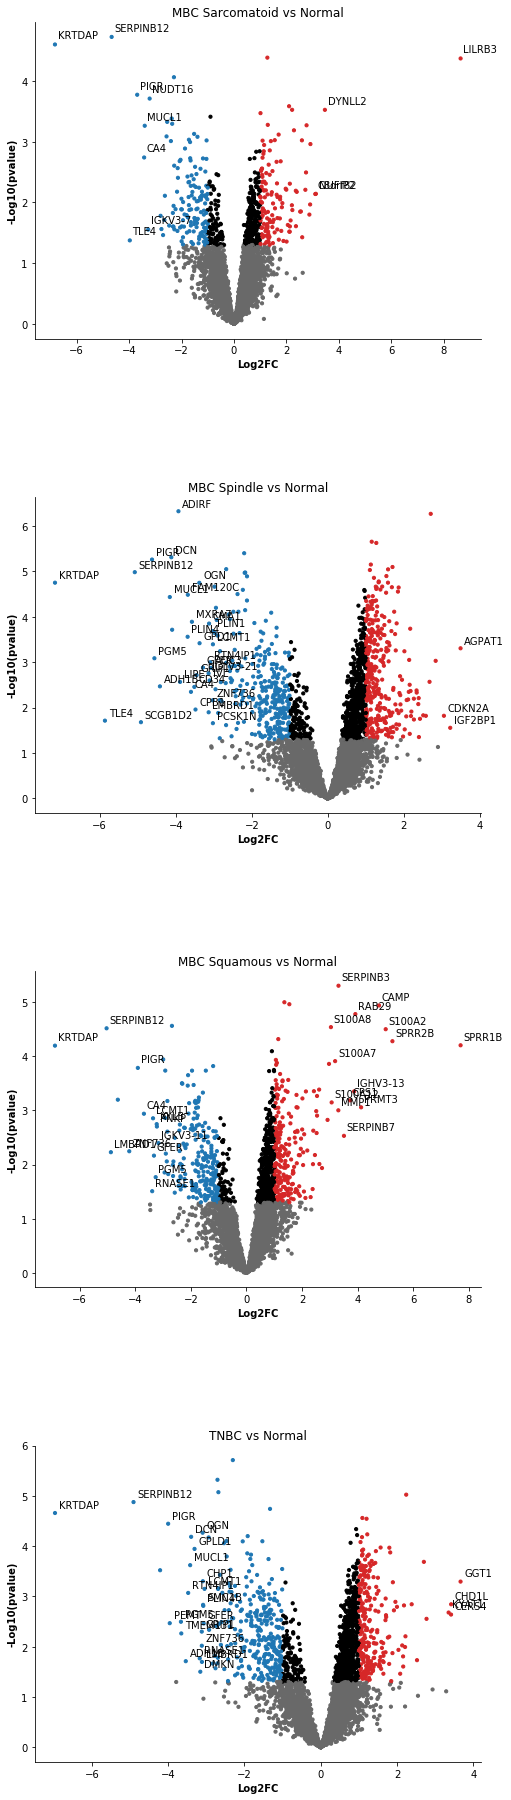

In [21]:
def preprocess(s):
    return s.split('|')[-1]

result = pd.read_csv('./Cancer_Normal_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32), dpi=500)
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(410 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        if row['Protein'] == "sp|P0DOX6|IGM_HUMAN":
            continue
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

#### Comparing the top 10 most significant changed proteins with the article

####  In terms of MBC Sarcomatoid subtype, the intersection of the top 10 most significant upRegulated proteins given in the article with our top 10 most significant upRegulated proteins is 0. Seven of these proteins are included in our quantitative protein and 4 of these proteins are included in our upRegulated proteins.  The intersection of the top 10 most significant downRegulated proteins given in the article with our top 10 most significant downRegulated proteins is 0. Seven of these proteins are included in our quantitative protein.

#### In terms of MBC Spindle subtype, the intersection of the top 10 most significant upRegulated proteins given in the article with our top 10 most significant upRegulated proteins is 0. Eight of these proteins are included in our upRegulated proteins. The intersection of the top 10 most significant downRegulated proteins given in the article with our top 10 most significant downRegulated proteins is 0. Nine of these proteins are included in our quantitative protein and seven of these proteins  are included in our downRegulated protein.

#### In terms of MBC Squamous subtype, the intersection of the top 10 most significant upRegulated proteins given in the article with our top 10 most significant upRegulated proteins is 0. Seven of these proteins are included in our quantitative proteins. The intersection of the top 10 most significant downRegulated proteins given in the article with our top 10 most significant downRegulated proteins is 0. Eight of these proteins are included in our quantitative protein and five of these proteins are included in our downRegulated protein.

#### In terms of TNBC,  the intersection of the top 10 most significant upRegulated proteins given in the article with our top 10 most significant upRegulated proteins is 1. eight of these proteins are included in our quantitative proteins. The intersection of the top 10 most significant downRegulated proteins given in the article with our top 10 most significant downRegulated proteins is 1. Seven of these proteins are included in our quantitative protein and Six of these proteins are included in our downRegulated protein.

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MBC Sarcomatoid vs Normal DownRegulated proteins: 143
MBC Sarcomatoid vs Normal UpRegulated proteins: 137
The top 10 most significant upRegulated proteins in MBC Sarcomatoid vs Normal : LILRB3,DYNLL2,NUFIP2,C8orf82,TOMM6,S100A1,CDC42SE1,UBA52,COL2A1,FABP6
The top 10 most significant downRegulated proteins in MBC Sarcomatoid vs Normal : TRMT10C,CALML3,NUDT16,IGKV3-7,MUCL1,CA4,PIGR,TLE4,SERPINB12,KRTDAP


<Figure size 3000x2000 with 0 Axes>

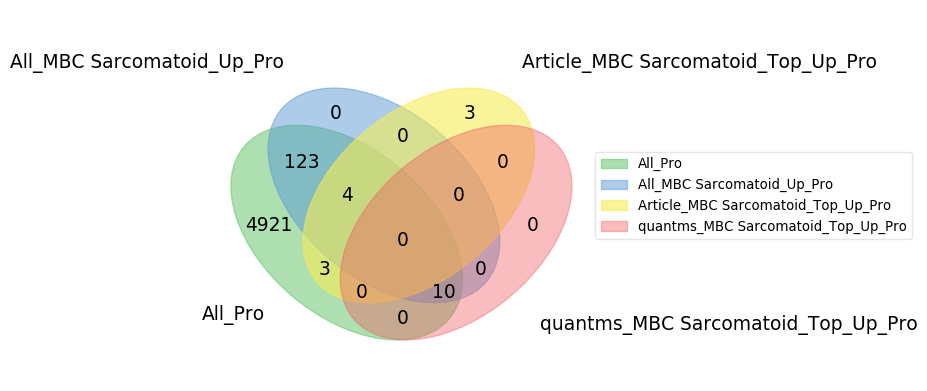

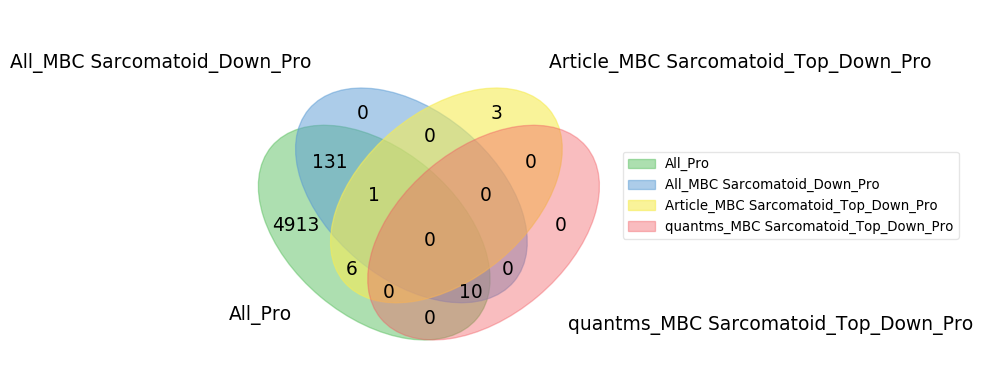

The shared proteins: UQCRH,MLLT1,PCLAF,PTX3,SNRNP27,GOLT1B,ARFGEF2
The shared proteins: GNB1,CDH5,KANK2,CAP2,STAB1,HNMT,CD99


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MBC Spindle vs Normal DownRegulated proteins: 323
MBC Spindle vs Normal UpRegulated proteins: 334
The top 10 most significant upRegulated proteins in MBC Spindle vs Normal : AGPAT1,IGF2BP1,CDKN2A,EXOSC6,H3C13/H3C14/H3C15,LSM14B,CDK6,TRIM2,CTDSPL2,TFAP2C
The top 10 most significant downRegulated proteins in MBC Spindle vs Normal : DCN,MUCL1,ADH1B,PGM5,PIGR,SCGB1D2,SERPINB12,TLE4,KRTDAP


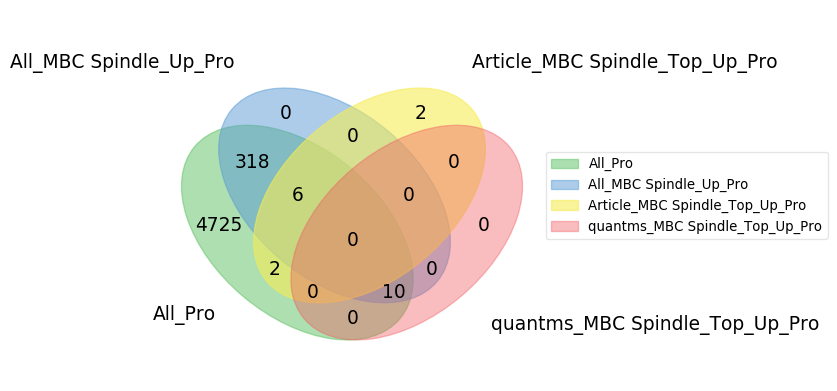

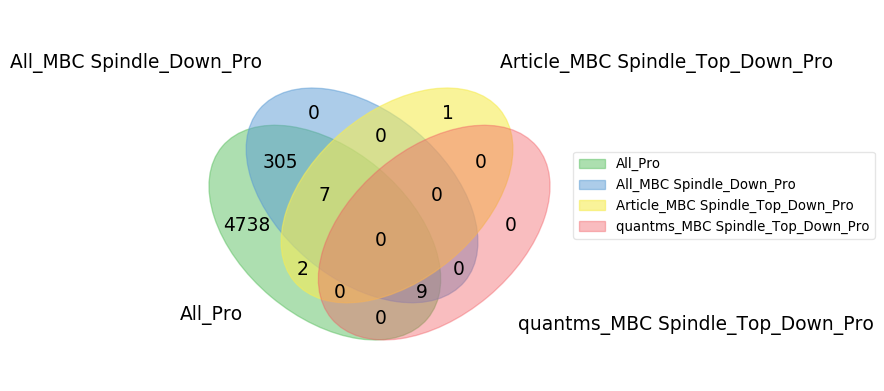

The shared proteins: RPL28,PLOD1,CALU,MSL1,SDC2,PDIA4,RPS28,CNN2
The shared proteins: CLEC3B,MYH11,CFD,SHMT1,IDO1,LILRB5,PODN,LTBP4,CPA3


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MBC Squamous vs Normal DownRegulated proteins: 238
MBC Squamous vs Normal UpRegulated proteins: 244
The top 10 most significant upRegulated proteins in MBC Squamous vs Normal : SPRR1B,SPRR2B,S100A2,CAMP,PRMT3,RAB29,IGHV3-13,CPS1,SERPINB7,SERPINB3
The top 10 most significant downRegulated proteins in MBC Squamous vs Normal : GFER,LCMT1,RNASE1,CA4,PIGR,ZNF736,LMBRD1,SERPINB12,KRTDAP


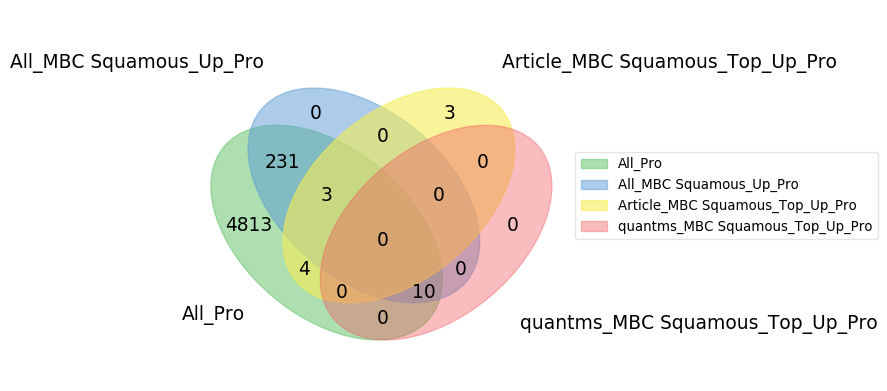

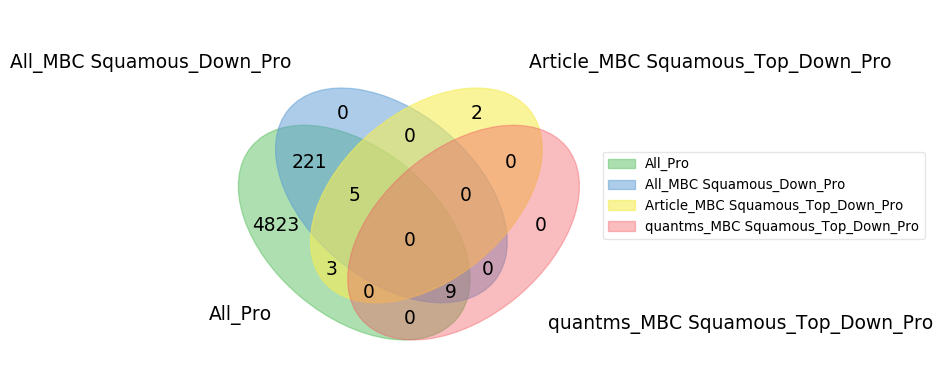

The shared proteins: PAIP2,CNN2,LSP1,ZCCHC17,TMEM70,SASH3,KRT5
The shared proteins: MAMDC2,DPT,HSPB6,CFD,AKAP12,GPT,SERPINC1,DCN


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


TNBC vs Normal DownRegulated proteins: 313
TNBC vs Normal UpRegulated proteins: 250
The top 10 most significant upRegulated proteins in TNBC vs Normal : GGT1,CHD1L,CERS4,KYAT1,MLLT1,SNRNP27,RNF170,UBA52,H3C13/H3C14/H3C15,IVNS1ABP
The top 10 most significant downRegulated proteins in TNBC vs Normal : MUCL1,RTN4IP1,ADH1B,TMEM131,PGM5,PEMT,PIGR,SERPINB12,KRTDAP


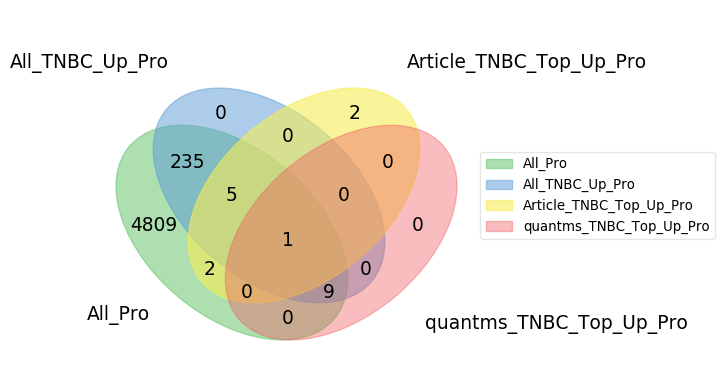

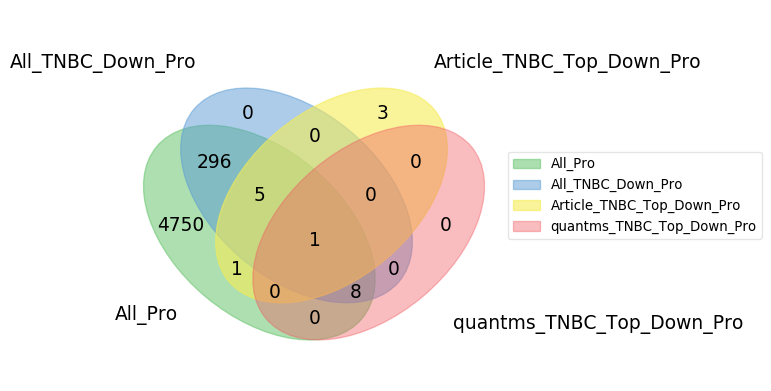

The shared proteins: HAT1,APC,ESPN,HMGA1,SNRNP27,FOXP4,THBS1,STMN1
The shared proteins: PLTP,TNXB,CFD,DES,SHMT1,STAB1,ADH1B


In [24]:
result = pd.read_csv('./Cancer_Normal_Comp_result.csv', sep=',')

def preprocess(s):
    return s.split('|')[-1]

Article_Top_Up_Pro = {"TNBC vs Normal": ['HMGA1', 'RREB1', 'THBS1', 'ESPN', 'HAT1', 'APC', 'FOXP4', 'GPRC5A', 'SNRNP27', 'STMN1'],
                     "MBC Spindle vs Normal": ['RPS28', 'PLOD1', 'CALU', 'PDIA4', 'RPL28', 'CNN2', 'HIST3H2BB', 'RPL39', 'SDC2', 'MSL1'],
                     "MBC Squamous vs Normal": ['ZCCHC17', 'KRT5', 'SNUPN', 'CNN2', 'FOSL2', 'LSP1', 'SASH3', 'TMEM70', 'TLDC1', 'PAIP2'],
                     "MBC Sarcomatoid vs Normal": ['ARFGEF2', 'PCLAF', 'PTX3', 'TMEM230', 'TAF6L', 'UQCRH', 'SNRNP27', 'RREB1', 'MLLT1', 
                                                   'GOLT1B']}

Article_Top_Down_Pro = {"TNBC vs Normal": ['FCGRT', 'ADH1B', 'SHMT1', 'STAB1', 'PLTP', 'DES', 'CFD', 'IGLV211', 'IGHG1', 'TNXB'],
                       "MBC Spindle vs Normal": ['ARRDC5', 'IDO1', 'LTBP4', 'SHMT1', 'CLEC3B', 'CFD', 'CPA3', 'MYH11', 'LILRB5', 'PODN'],
                        "MBC Squamous vs Normal": ['HSPB6', 'PEX12', 'AKAP12', 'DCN', 'CFD', 'DPT', 'IGLV211', 'SERPINC1', 'MAMDC2', 'GPT'],
                       "MBC Sarcomatoid vs Normal": ['CDH5', 'FADD', 'CAP2', 'MSRA', 'GNB1', 'CD99', 'STAB1', 'KANK2', 'HNMT', 'CPM']}

plt.figure(dpi=500)
for comp in np.unique(result['Label']):
    t = result[result["Label"] == comp]
    t_All = t['Protein'].tolist()
    t_All_Pro = MapProtGeneName(list(map(preprocess, t_All))).values()

    t_Up = t[(t['log2FC'] > 1)&(t['pvalue'] < 0.05)]
    t_Down = t[(result['log2FC'] < -1)&(t['pvalue'] < 0.05)]
    print(comp + " DownRegulated proteins: %d" %(len(set(t_Down['Protein']))))
    print(comp + " UpRegulated proteins: %d" %(len(set(t_Up['Protein']))))

    # ALL the differential changed proteins
    ALL_t_Up_Pro  = MapProtGeneName(list(map(preprocess, t_Up['Protein'].tolist()))).values()
    ALL_t_Down_Pro = MapProtGeneName(list(map(preprocess, t_Down['Protein'].tolist()))).values()

    # The list of the top 10 most significant up- and downregulated proteins are given in the article.
    Article_t_Top_Down_Pro = Article_Top_Down_Pro[comp]
    Article_t_Top_Up_Pro = Article_Top_Up_Pro[comp]

    # UpRegulated proteins top 10
    Our_t_Top_Up_Pro = MapProtGeneName(list(map(preprocess, t_Up.sort_values(["log2FC"],ascending=False).head(10)['Protein'].tolist()))).values()
    print("The top 10 most significant upRegulated proteins in " + comp + " : " + ",".join(Our_t_Top_Up_Pro))

    # top 10 downRegulated protein 
    Our_t_Top_Down_Pro = MapProtGeneName(list(map(preprocess, t_Down.sort_values(["log2FC"],ascending=False).tail(10)['Protein'].tolist()))).values()
    print("The top 10 most significant downRegulated proteins in " + comp + " : " + ",".join(Our_t_Top_Down_Pro))

    labels = venn.get_labels([set(t_All_Pro), set(ALL_t_Up_Pro), set(Article_t_Top_Up_Pro), set(Our_t_Top_Up_Pro)], fill=['number'])
    fig, ax = venn.venn4(labels, names=['All_Pro', 'All_' + comp.replace(" vs Normal", '') + '_Up_Pro', 'Article_' + comp.replace(" vs Normal", '') + '_Top_Up_Pro', 'quantms_' 
                                         + comp.replace(" vs Normal", '') + '_Top_Up_Pro'], figsize=(5, 10))
    plt.show()
    
    labels = venn.get_labels([set(t_All_Pro), set(ALL_t_Down_Pro), set(Article_t_Top_Down_Pro), set(Our_t_Top_Down_Pro)], fill=['number'])
    fig, ax = venn.venn4(labels, names=['All_Pro', 'All_' + comp.replace(" vs Normal", '') + '_Down_Pro', 'Article_' + comp.replace(" vs Normal", '') + '_Top_Down_Pro', 'quantms_' 
                                         + comp.replace(" vs Normal", '') + '_Top_Down_Pro'], figsize=(5, 10))
    plt.show()
    
    print("The shared proteins: " + ",".join(set(t_All_Pro).intersection(set(Article_t_Top_Up_Pro))))
    print("The shared proteins: " + ",".join(set(t_All_Pro).intersection(set(Article_t_Top_Down_Pro))))

#### Volcano plots comparing MBC with TNBC and within MBC subtype (Corresponding figure 3 B)

                     Protein                    Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  SQUAMOUS vs SARCOMATOID  1.849715  0.170908   
1   sp|A0A075B6H7|KV37_HUMAN   SPINDLE vs SARCOMATOID  0.217056  0.889342   
2   sp|A0A075B6H7|KV37_HUMAN      SPINDLE vs SQUAMOUS -1.632659  0.310619   
3  sp|A0A075B6I0|LV861_HUMAN  SQUAMOUS vs SARCOMATOID -1.703542  0.004881   
4  sp|A0A075B6I0|LV861_HUMAN   SPINDLE vs SARCOMATOID -0.455573  0.370977   

   -Log10(p-value)     group  
0         0.767238   dimgrey  
1         0.050931   dimgrey  
2         0.507772   dimgrey  
3         2.311514  tab:blue  
4         0.430653   dimgrey  
['sp|O43815|STRN_HUMAN', 'sp|O75022|LIRB3_HUMAN', 'sp|P0DOX6|IGM_HUMAN', 'sp|P52564|MP2K6_HUMAN', 'sp|P69892|HBG2_HUMAN', 'sp|Q00534|CDK6_HUMAN', 'sp|Q7Z417|NUFP2_HUMAN', 'sp|Q8ND24|RN214_HUMAN', 'sp|Q8NDV3|SMC1B_HUMAN', 'sp|Q96DE0|NUD16_HUMAN', 'sp|Q9NRR8|C42S1_HUMAN', 'sp|Q9NWT1|PK1IP_HUMAN']
['sp|O00757|F16P2_HUMAN', 'sp|O60678|ANM3_HUMAN', 'sp|P

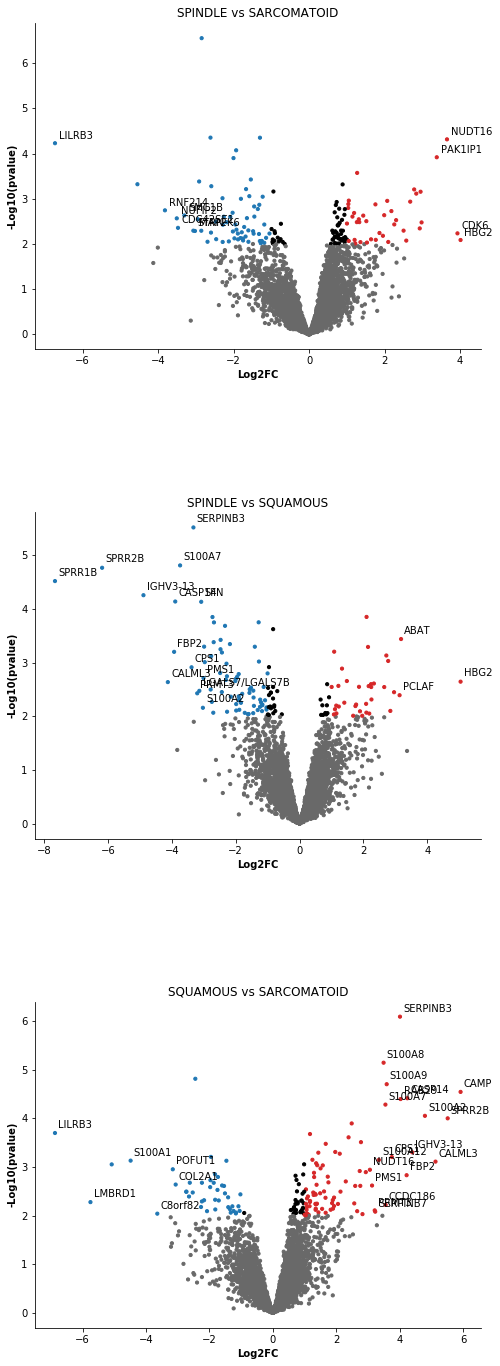

In [25]:
result = pd.read_csv('./Within_Subtype_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())


fig = plt.figure(figsize=(8, 24), dpi=500)
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)

    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    print(data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        if row['Protein'] == "sp|P0DOX6|IGM_HUMAN":
            continue
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


In [26]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')

raw.om$Condition[which(raw.om$Condition == "metaplastic breast carcinomas|Chondroid"|raw.om$Condition=="metaplastic breast carcinomas|Spindle"|raw.om$Condition=="metaplastic breast carcinomas|Squamous")] <- "MBC"
raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

input.om <- OpenMStoMSstatsTMTFormat(raw.om)

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

print(levels(quant_om.msstats$ProteinLevelData$Condition))

INFO  [2021-11-26 19:33:59] ** Raw data from OpenMS imported successfully.
INFO  [2021-11-26 19:34:01] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-11-26 19:34:02] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-11-26 19:34:02] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-11-26 19:34:02] ** Shared peptides are removed.
INFO  [2021-11-26 19:34:02] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-11-26 19:34:16] ** PSMs have been aggregated to peptide ions.
INFO  [2021-11-26 19:34:19] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-11-26 19:34:21] ** For peptides overl

In [27]:
%%R

MBC_TNBC_Comp<-matrix(c(1,0,-1),nrow=1)
row.names(MBC_TNBC_Comp)<-c("MBC vs TNBC")
colnames(MBC_TNBC_Comp) = c("MBC","Normal|Normal breast", "Triple-negative breast cancer|Triple-negative")


MBC_TNBC_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = MBC_TNBC_Comp, moderated = TRUE)
MBC_TNBC_Comp = MBC_TNBC_Comp.pairwise$ComparisonResult
write.table(MBC_TNBC_Comp,"MBC_TNBC_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-11-26 19:37:45] Model fitting for 5069 proteins.
  |======================================================================| 100%
INFO  [2021-11-26 19:40:30] Testing for 5069 proteins:
  |======================================================================| 100%


                     Protein        Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  MBC vs TNBC  0.016080  0.988255   
1  sp|A0A075B6I0|LV861_HUMAN  MBC vs TNBC  0.563282  0.223648   
2  sp|A0A075B6J9|LV218_HUMAN  MBC vs TNBC  0.126562  0.819117   
3  sp|A0A075B6K0|LV316_HUMAN  MBC vs TNBC  1.009940  0.444313   
4   sp|A0A075B6K5|LV39_HUMAN  MBC vs TNBC  0.547153  0.260326   

   -Log10(p-value)    group  
0         0.005131  dimgrey  
1         0.650435  dimgrey  
2         0.086654  dimgrey  
3         0.352311  dimgrey  
4         0.584483  dimgrey  


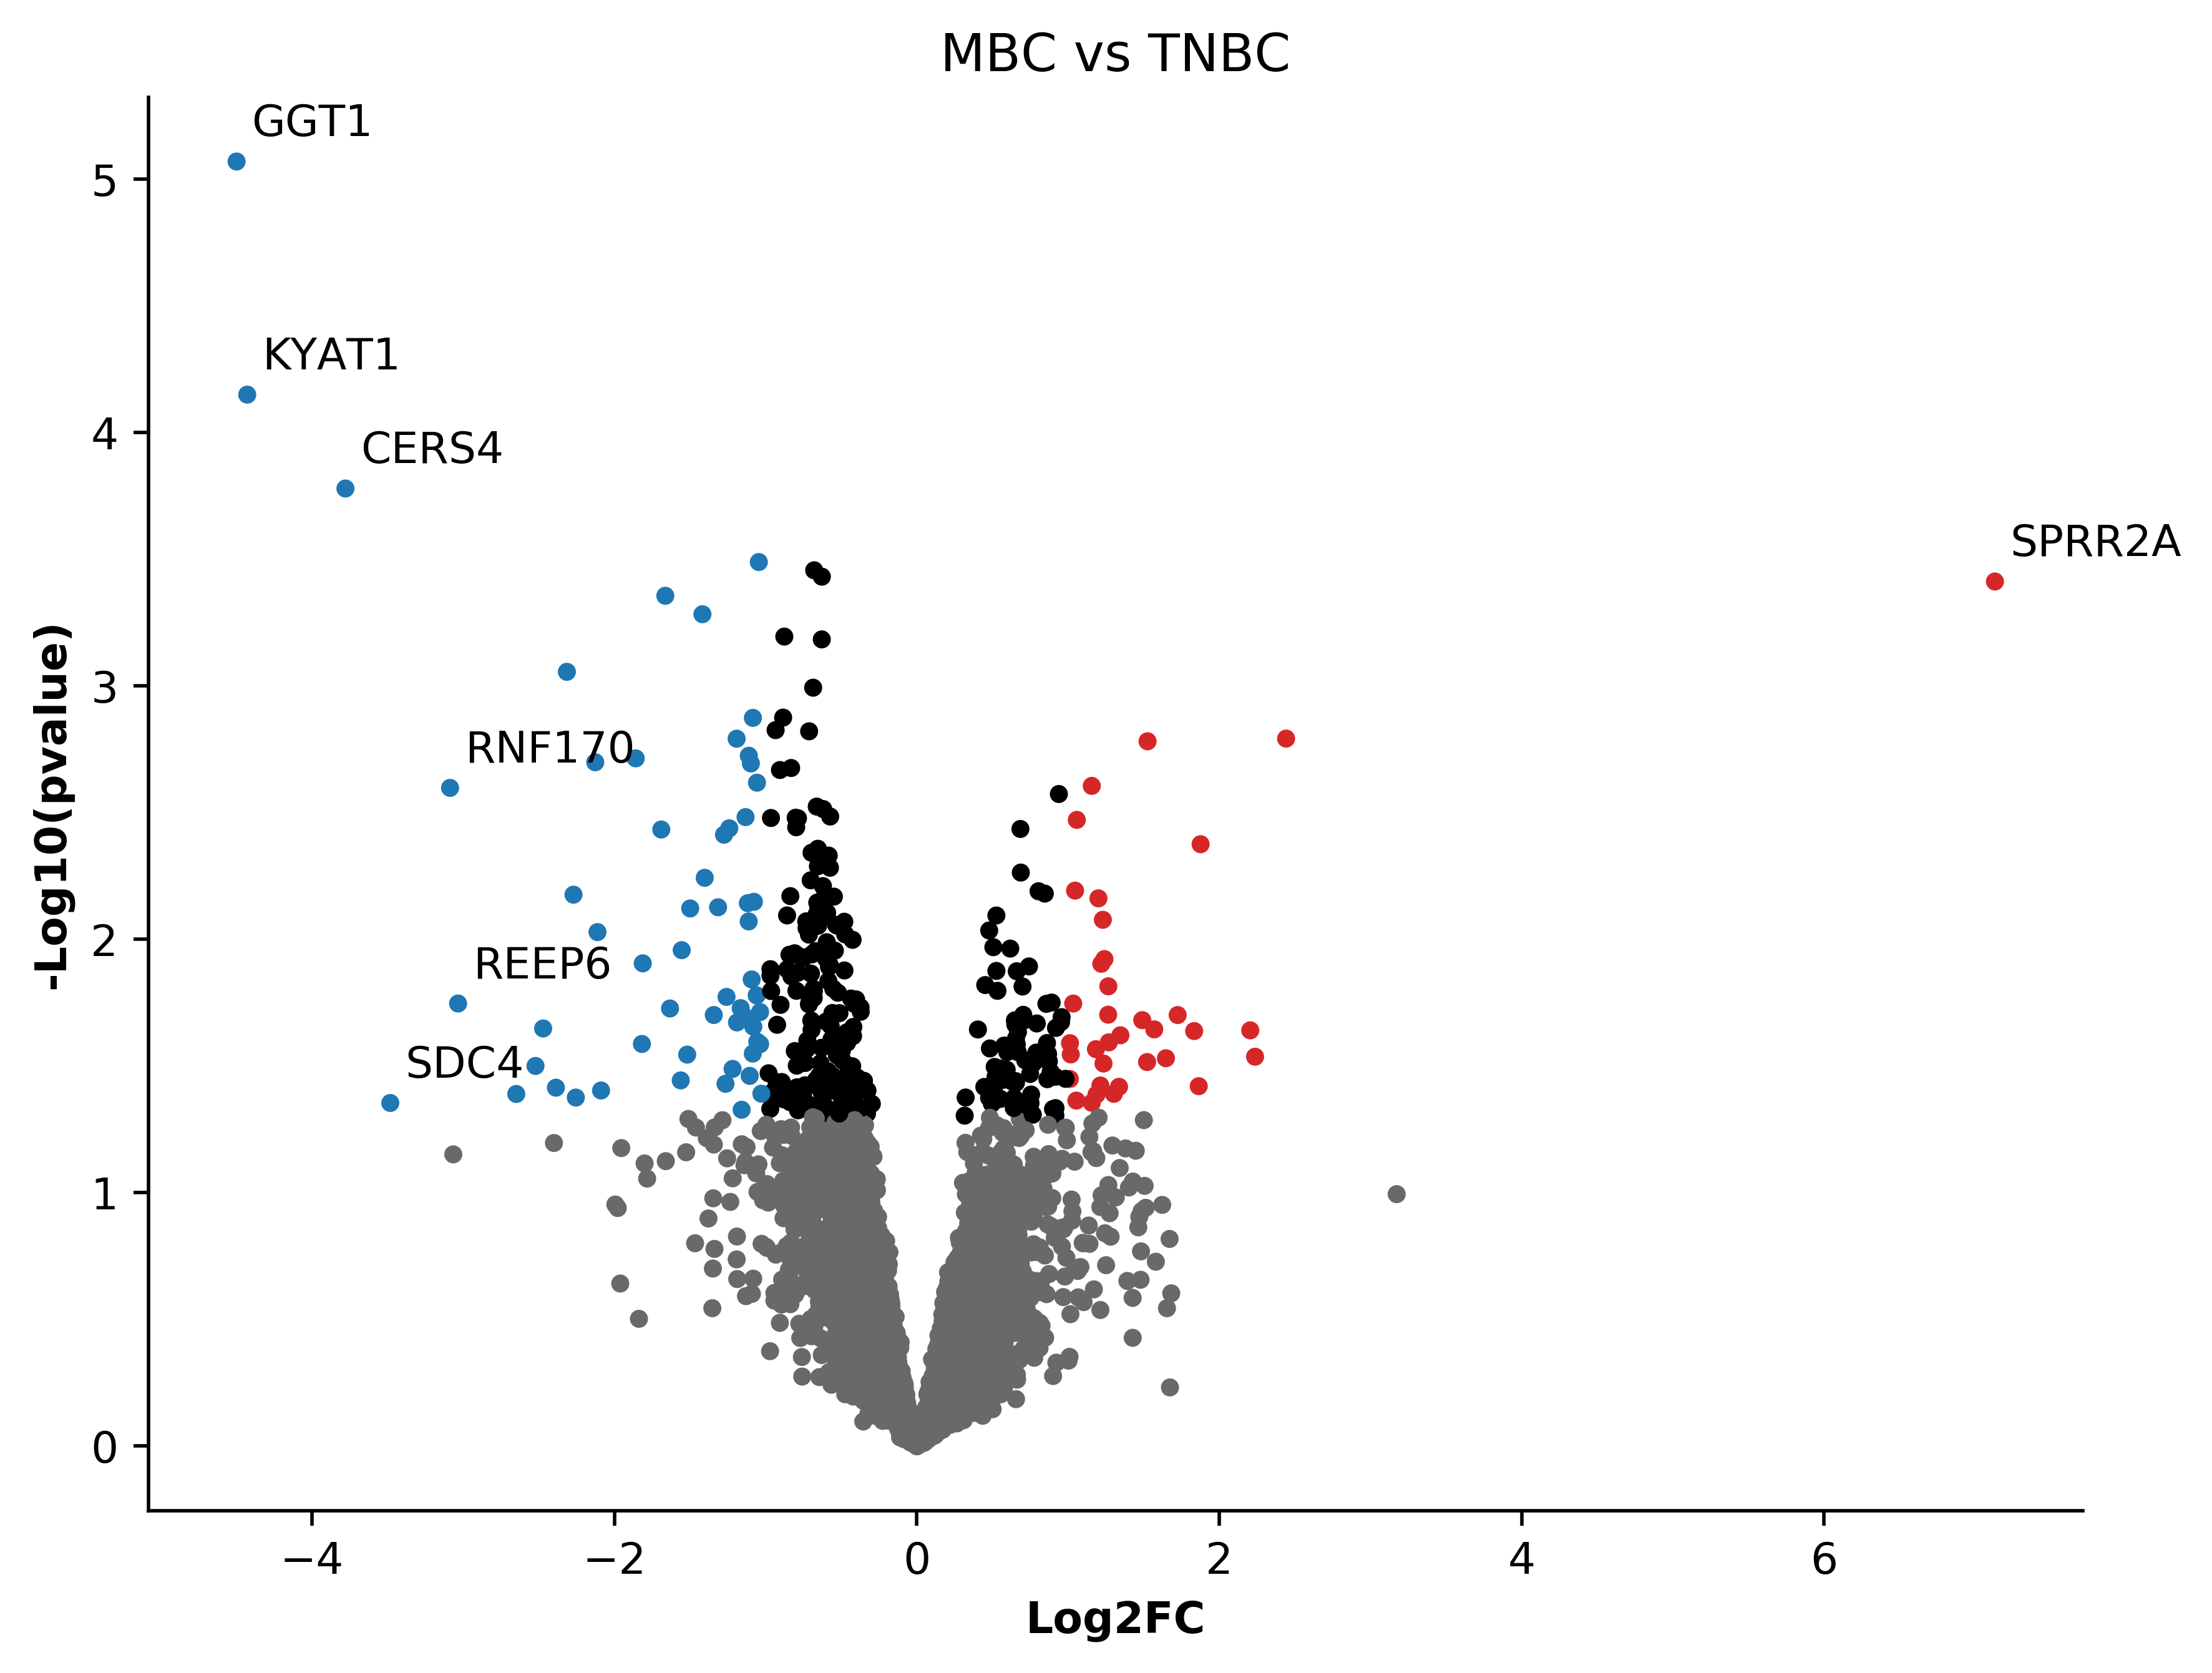

In [28]:
result = pd.read_csv('./MBC_TNBC_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())


fig = plt.figure(figsize=(8, 6), dpi=500)
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(110 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        if row['Protein'] == "sp|P0DOX6|IGM_HUMAN":
            continue
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

### Protein expression Heatmaps

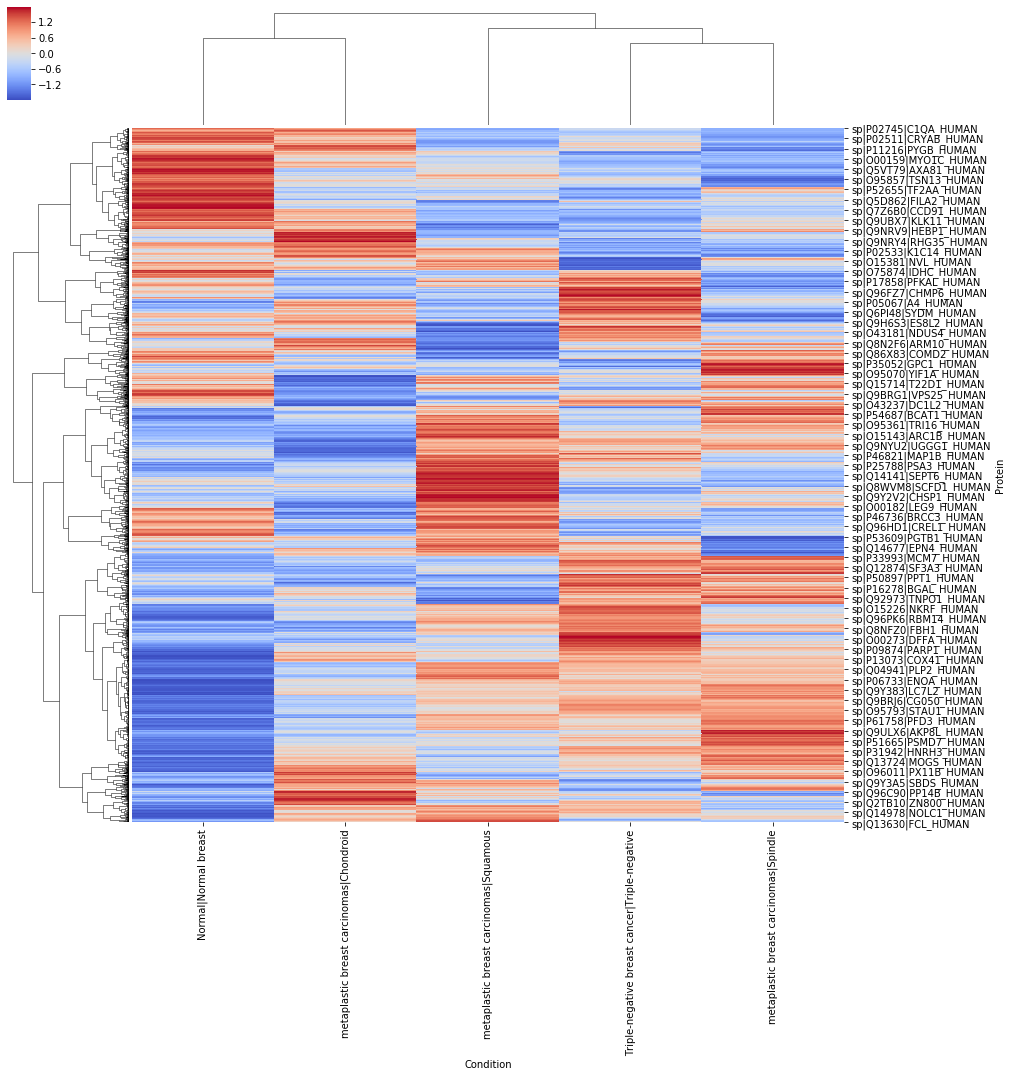

In [29]:
# Data set
url = './protein_expression.csv'
df = pd.read_csv(url)

df2 = df.pivot_table(index='Protein', columns='Condition', values='Abundance',aggfunc=np.mean)
df2 = df2.dropna()

# plot

g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()